In [2]:
# --- FIXED COLAB INSTALL CELL (Torch 2.9 compatible) ---

!pip install --quiet kagglehub timm opacus fairlearn shap captum networkx matplotlib pandas Pillow

# Install torchvision compatible with Torch 2.9 (requires >=0.20)
!pip install --quiet torchvision --index-url https://download.pytorch.org/whl/cu126

import torch, sys
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
import torchvision
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 20.2 MB/s eta 0:00:00
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch: 2.9.0+cu126
Torchvision: 0.24.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [3]:
# --- FIXED INSTALL CELL FOR TORCH 2.9 + CUDA 12.6 ---

!pip install --quiet kagglehub timm opacus fairlearn shap captum networkx matplotlib pandas Pillow scikit-learn

# Install torchvision compatible with torch==2.9.0 (cu126)
!pip install --quiet torchvision --index-url https://download.pytorch.org/whl/cu126

import torch, torchvision, sys
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


Python: 3.12.12
Torch: 2.9.0+cu126
Torchvision: 0.24.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [4]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

ROOT = Path("/content/drive/MyDrive/FedMultimodalProject")
DATA = ROOT / "datasets"
MODELS = ROOT / "models"
LOGS = ROOT / "logs"

for p in (DATA, MODELS, LOGS):
    p.mkdir(parents=True, exist_ok=True)

ROOT, DATA


Mounted at /content/drive


(PosixPath('/content/drive/MyDrive/FedMultimodalProject'),
 PosixPath('/content/drive/MyDrive/FedMultimodalProject/datasets'))

In [5]:
import torch, random, numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Seed set =", SEED)


Seed set = 42


In [6]:
import kagglehub

# Download to default KaggleHub cache directory
FF_PATH = kagglehub.dataset_download("abdulwasay551/fairface-race")
adult_path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("FairFace →", FF_PATH)
print("Adult Income →", adult_path)


100%|██████████| 2.41G/2.41G [00:28<00:00, 91.1MB/s]

Extracting files...


Using Colab cache for faster access to the 'adult-income-dataset' dataset.
FairFace → /root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2
Adult Income → /kaggle/input/adult-income-dataset


In [7]:
import os
from pathlib import Path

base = Path(FF_PATH) / "FairFace Race"
train_aligned = base / "train_aligned"
val_aligned = base / "val_aligned"

def count_imgs(path):
    print("\nFolder:", path)
    for race in sorted(path.iterdir()):
        if race.is_dir():
            count = len(list(race.glob("*.jpg")))
            print(f"  {race.name:18s} : {count}")

count_imgs(train_aligned)
count_imgs(val_aligned)



Folder: /root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2/FairFace Race/train_aligned
  Asian              : 4000
  Black              : 4000
  Indian             : 4000
  Latino_Hispanic    : 4000
  Middle Eastern     : 3977
  White              : 4000

Folder: /root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2/FairFace Race/val_aligned
  Asian              : 437
  Black              : 225
  Indian             : 467
  Latino_Hispanic    : 660
  Middle Eastern     : 258
  White              : 716


Class: White
Image: /root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2/FairFace Race/train_aligned/White/aligned_72938.jpg


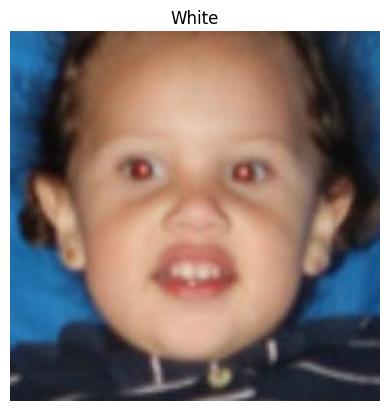

In [8]:
from PIL import Image
import random
import matplotlib.pyplot as plt

classes = sorted([d for d in train_aligned.iterdir() if d.is_dir()])
c = random.choice(classes)
img = random.choice(list(c.glob("*.jpg")))

print("Class:", c.name)
print("Image:", img)

plt.imshow(Image.open(img))
plt.title(c.name)
plt.axis('off')
plt.show()


In [9]:
import pandas as pd

adult_csv = Path(adult_path) / "adult.csv"
adult_df = pd.read_csv(adult_csv)

print(adult_df.shape)
adult_df.head()


(48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
print("Race counts:\n", adult_df["race"].value_counts(), "\n")
print("Gender counts:\n", adult_df["gender"].value_counts(), "\n")
print("Income counts:\n", adult_df["income"].value_counts(), "\n")

Race counts:
 race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64 

Gender counts:
 gender
Male      32650
Female    16192
Name: count, dtype: int64 

Income counts:
 income
<=50K    37155
>50K     11687
Name: count, dtype: int64 



In [11]:
import json

manifest = {
    "fairface_path": str(FF_PATH),
    "adult_path": str(adult_path),
    "seed": SEED
}

manifest_file = DATA / "manifest.json"
with open(manifest_file, "w") as f:
    json.dump(manifest, f, indent=2)

print(open(manifest_file).read())


{
  "fairface_path": "/root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2",
  "adult_path": "/kaggle/input/adult-income-dataset",
  "seed": 42
}


In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import joblib


In [13]:
IMG_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = adult_df.copy()

# sanitize column names
df.columns = [c.strip().lower().replace("-", "_") for c in df.columns]
df["income"] = df["income"].apply(lambda x: 1 if str(x).strip().startswith(">") else 0)

num_cols = ['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week']
cat_cols = [c for c in df.columns if c not in num_cols + ['income']]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

X = df.drop(columns=['income'])
y = df['income']

pre.fit(X)

import joblib
joblib.dump(pre, DATA / "adult_preprocessor.joblib")

print("Preprocessor saved successfully!")
print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)


Preprocessor saved successfully!
Numeric features: ['age', 'fnlwgt', 'educational_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical features: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']


In [15]:
import random

# list all FairFace train images
images = sorted(list((train_aligned).rglob("*.jpg")))
print("Train images:", len(images))

# shuffle adult rows deterministically
idxs = list(range(len(df)))
random.Random(SEED).shuffle(idxs)

pairs = list(zip(images, idxs))[:len(images)]

print("Paired samples:", len(pairs))


Train images: 23977
Paired samples: 23977


In [16]:
# FIXED MultimodalDataset for dict-based pairs from Cell 1.7

class MultimodalDataset(Dataset):
    def __init__(self, pairs, adult_df, transform, preprocessor):
        self.pairs = pairs                      # list of dicts now
        self.adult_df = adult_df.reset_index(drop=True)
        self.transform = transform
        self.pre = preprocessor

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        entry = self.pairs[idx]

        # dict fields
        img_path = entry["image_path"]
        adult_idx = entry["adult_index"]

        # image
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        # tabular
        row = self.adult_df.iloc[[adult_idx]].drop(columns=['income'])
        tab = self.pre.transform(row).astype(np.float32)
        tab = torch.tensor(tab[0], dtype=torch.float32)

        # label
        label = torch.tensor(
            int(self.adult_df.iloc[adult_idx]['income']),
            dtype=torch.long
        )

        # sensitive attributes
        sensitive = {
            "image_race": entry["image_race"],
            "tabular_race": entry["tabular_race"],
            "gender": entry["gender"]
        }

        return {
            "image": img,
            "tabular": tab,
            "label": label,
            "sensitive": sensitive
        }


In [17]:
# ========================
# CELL 1.6 — BUILD CLEAN MULTIMODAL MAPPINGS
# ========================

import json, random
from pathlib import Path

# Ensure mapping directory exists
mapping_dir = DATA / "mappings"
mapping_dir.mkdir(parents=True, exist_ok=True)

# FairFace image locations
ff_base = Path(FF_PATH) / "FairFace Race"
train_imgs = sorted(list((ff_base / "train_aligned").rglob("*.jpg")))
val_imgs   = sorted(list((ff_base / "val_aligned").rglob("*.jpg")))

# Adult dataframe already loaded into `df`

n_adult = len(df)

# Deterministic shuffle of adult rows
idxs = list(range(n_adult))
random.Random(SEED).shuffle(idxs)

# --------------------------
# BUILD TRAIN MAPPINGS
# --------------------------
train_pairs = []
n_train = min(len(train_imgs), n_adult)

for i in range(n_train):
    adult_idx = idxs[i]
    entry = {
        "pair_index": i,
        "image_path": str(train_imgs[i]),
        "adult_index": int(adult_idx),
        "image_race": Path(train_imgs[i]).parent.name,
        "tabular_race": str(df.iloc[adult_idx]["race"]),
        "gender": str(df.iloc[adult_idx]["gender"])
    }
    train_pairs.append(entry)

# --------------------------
# BUILD VAL MAPPINGS
# --------------------------
val_pairs = []
n_val = min(len(val_imgs), n_adult - n_train)
start_val_idx = n_train  # ensures train/val pairs are disjoint

for j in range(n_val):
    adult_idx = idxs[start_val_idx + j]
    entry = {
        "pair_index": j,
        "image_path": str(val_imgs[j]),
        "adult_index": int(adult_idx),
        "image_race": Path(val_imgs[j]).parent.name,
        "tabular_race": str(df.iloc[adult_idx]["race"]),
        "gender": str(df.iloc[adult_idx]["gender"])
    }
    val_pairs.append(entry)

# Save to JSON
with open(mapping_dir / "train_full_multimodal_mapping.json", "w") as f:
    json.dump({"pairs": train_pairs, "n_pairs": len(train_pairs), "seed": SEED}, f, indent=2)

with open(mapping_dir / "val_full_multimodal_mapping.json", "w") as f:
    json.dump({"pairs": val_pairs, "n_pairs": len(val_pairs), "seed": SEED}, f, indent=2)

print("Saved:")
print(" ", mapping_dir / "train_full_multimodal_mapping.json")
print(" ", mapping_dir / "val_full_multimodal_mapping.json")

print("\nSample train pair:")
print(train_pairs[0])

print("\nSample val pair:")
print(val_pairs[0])


Saved:
  /content/drive/MyDrive/FedMultimodalProject/datasets/mappings/train_full_multimodal_mapping.json
  /content/drive/MyDrive/FedMultimodalProject/datasets/mappings/val_full_multimodal_mapping.json

Sample train pair:
{'pair_index': 0, 'image_path': '/root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2/FairFace Race/train_aligned/Asian/24_0_2_20161219190613907.jpg.chip.jpg', 'adult_index': 5060, 'image_race': 'Asian', 'tabular_race': 'White', 'gender': 'Male'}

Sample val pair:
{'pair_index': 0, 'image_path': '/root/.cache/kagglehub/datasets/abdulwasay551/fairface-race/versions/2/FairFace Race/val_aligned/Asian/aligned_1.jpg', 'adult_index': 29114, 'image_race': 'Asian', 'tabular_race': 'Black', 'gender': 'Female'}


In [18]:
# ========================
# CELL 1.7 — LOAD PAIRS AND TEST DATALOADER
# ========================

import json

# Load dict-based mappings
with open(mapping_dir / "train_full_multimodal_mapping.json") as f:
    train_pairs = json.load(f)["pairs"]

with open(mapping_dir / "val_full_multimodal_mapping.json") as f:
    val_pairs = json.load(f)["pairs"]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))

# Load preprocessor
pre = joblib.load(DATA / "adult_preprocessor.joblib")

# Build datasets
train_ds = MultimodalDataset(train_pairs, df, train_tf, pre)
val_ds   = MultimodalDataset(val_pairs, df, val_tf, pre)

# Test dataloader
dl = DataLoader(train_ds, batch_size=8, shuffle=False, num_workers=0)
batch = next(iter(dl))

print("Image:", batch["image"].shape)
print("Tabular:", batch["tabular"].shape)
print("Label:", batch["label"].shape)

print("\nSensitive example:")
print(" image_race  :", batch["sensitive"]["image_race"][0])
print(" tabular_race:", batch["sensitive"]["tabular_race"][0])
print(" gender      :", batch["sensitive"]["gender"][0])


Train pairs: 23977
Val pairs: 2763
Image: torch.Size([8, 3, 224, 224])
Tabular: torch.Size([8, 108])
Label: torch.Size([8])

Sensitive example:
 image_race  : Asian
 tabular_race: White
 gender      : Male


In [19]:
# DAY 2 - Cell 2.1

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [20]:
# Cell 2.0 - quick sanity
import torch, random, numpy as np
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Seed:", SEED)


Device: cuda
Seed: 42


In [21]:
# Cell 2.1 - imports
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import joblib, os
import timm   # timm should be installed already from Day0; if not: !pip install timm
from pathlib import Path
print("timm:", timm.__version__)


timm: 1.0.22


In [22]:
# Cell 2.2 - Image encoder
class ImageEncoder(nn.Module):
    def __init__(self, model_name="efficientnet_b0", pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        # timm's EfficientNet has .classifier; remove final head and keep num_features
        if hasattr(self.backbone, 'classifier'):
            self.backbone.classifier = nn.Identity()
        elif hasattr(self.backbone, 'fc'):
            self.backbone.fc = nn.Identity()
        self.out_features = self.backbone.num_features

    def forward(self, x):
        # returns [B, out_features]
        return self.backbone(x)

# quick instantiation check
img_enc = ImageEncoder()
print("Image encoder out dim:", img_enc.out_features)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Image encoder out dim: 1280


In [23]:
# Cell 2.3 - FT-style tabular encoder
class FTTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_mlp = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out_dim = d_model

    def forward(self, x):
        # x: [B, input_dim] -> [B, d_model]
        x = self.input_mlp(x)
        x = x.unsqueeze(1)            # [B, 1, d_model]
        x = self.transformer(x)       # [B, 1, d_model]
        return x[:, 0, :]             # [B, d_model]


In [24]:
# Cell 2.4 - Fusion model
class MultimodalFusion(nn.Module):
    def __init__(self, img_encoder, tab_encoder, hidden_dim=256, num_classes=2, dropout=0.3):
        super().__init__()
        self.img_encoder = img_encoder
        self.tab_encoder = tab_encoder
        fusion_dim = img_encoder.out_features + tab_encoder.out_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, img, tab):
        img_emb = self.img_encoder(img)     # [B, img_dim]
        tab_emb = self.tab_encoder(tab)     # [B, tab_dim]
        fused = torch.cat([img_emb, tab_emb], dim=1)
        return self.classifier(fused)


In [25]:
# CELL 2.0 — MUST RUN BEFORE BUILDING THE MODEL

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [26]:
# Cell 2.5 - instantiate full model
# compute tabular input dim by transforming one sample (drop income)
sample_row = df.drop(columns=['income']).iloc[[0]]
sample_trans = pre.transform(sample_row)
input_dim = sample_trans.shape[1]

print("Tabular input dim:", input_dim)

img_enc = ImageEncoder()
tab_enc = FTTransformer(input_dim=input_dim, d_model=128, n_heads=4, num_layers=2)
model = MultimodalFusion(img_enc, tab_enc).to(device)

print("Model instantiated. Total params (M):", sum(p.numel() for p in model.parameters())/1e6)


Tabular input dim: 108
Model instantiated. Total params (M): 4.779262


In [27]:
# Cell 2.6 - datasets & loaders
pre = joblib.load(DATA / "adult_preprocessor.joblib")

# reload mappings if needed
import json
mapping_dir = DATA / "mappings"
with open(mapping_dir / "train_full_multimodal_mapping.json") as f:
    train_pairs = json.load(f)["pairs"]
with open(mapping_dir / "val_full_multimodal_mapping.json") as f:
    val_pairs = json.load(f)["pairs"]

train_ds = MultimodalDataset(train_pairs, df, train_tf, pre)
val_ds   = MultimodalDataset(val_pairs, df, val_tf, pre)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# quick batch shapes
batch = next(iter(DataLoader(train_ds, batch_size=8, num_workers=0)))
print("Image batch:", batch["image"].shape)
print("Tabular batch:", batch["tabular"].shape)
print("Label batch:", batch["label"].shape)


Image batch: torch.Size([8, 3, 224, 224])
Tabular batch: torch.Size([8, 108])
Label batch: torch.Size([8])


In [28]:
# Cell 2.7 - one-epoch sanity training (limited steps)
import torch.nn as nn, time
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

model.train()
running_loss = 0.0
correct = 0
total = 0
start = time.time()
max_steps = 50   # set to None to run through full epoch

for step, batch in enumerate(train_loader):
    img = batch["image"].to(device)
    tab = batch["tabular"].to(device)
    labels = batch["label"].to(device)

    optimizer.zero_grad()
    out = model(img, tab)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()

    preds = out.argmax(1)
    running_loss += loss.item()
    correct += (preds == labels).sum().item()
    total += labels.size(0)

    if max_steps and (step+1) >= max_steps:
        break

end = time.time()
print(f"Steps: {step+1}, Time: {end-start:.1f}s, Avg loss: {running_loss/(step+1):.4f}, Acc: {correct/total:.4f}")


Steps: 50, Time: 15.9s, Avg loss: 0.4857, Acc: 0.7806


In [29]:
# Cell 2.8 - save checkpoint
torch.save(model.state_dict(), MODELS / "day2_fusion_init.pth")
print("Saved:", MODELS / "day2_fusion_init.pth")


Saved: /content/drive/MyDrive/FedMultimodalProject/models/day2_fusion_init.pth


In [30]:
# DAY 3 — Cell 3.1

import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict


In [31]:
# DAY 3 — Cell 3.2

def evaluate(model, loader):
    model.eval()
    all_labels, all_preds, all_sens = [], [], []

    with torch.no_grad():
        for batch in loader:
            img = batch["image"].to(device)
            tab = batch["tabular"].to(device)
            labels = batch["label"].to(device)

            out = model(img, tab)
            preds = out.argmax(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # sensitive attributes
            sr = batch["sensitive"]
            for i in range(len(labels)):
                all_sens.append({
                    "image_race": sr["image_race"][i],
                    "tabular_race": sr["tabular_race"][i],
                    "gender": sr["gender"][i]
                })

    return np.array(all_labels), np.array(all_preds), all_sens


In [32]:
# DAY 3 — Cell 3.3

def demographic_parity_gap(preds, sens_groups):
    groups = defaultdict(list)
    for p, s in zip(preds, sens_groups):
        groups[s].append(p)

    rates = {g: np.mean(v) for g, v in groups.items()}
    gap = max(rates.values()) - min(rates.values())
    return gap, rates


def equalized_odds_gap(labels, preds, sens_groups):
    groups = defaultdict(lambda: {"y": [], "p": []})

    for y, p, s in zip(labels, preds, sens_groups):
        groups[s]["y"].append(y)
        groups[s]["p"].append(p)

    tprs = {}
    for g, d in groups.items():
        y = np.array(d["y"])
        p = np.array(d["p"])
        tp = np.sum((y == 1) & (p == 1))
        fn = np.sum((y == 1) & (p == 0))
        tpr = tp / (tp + fn + 1e-8)
        tprs[g] = tpr

    gap = max(tprs.values()) - min(tprs.values())
    return gap, tprs


In [33]:
# DAY 3 — Cell 3.4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

EPOCHS = 3  # You can increase to 10+ later

history = {
    "train_loss": [],
    "train_acc": [],
    "val_acc": [],
    "dp_gap": [],
    "eo_gap": []
}

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    model.train()
    running_loss = 0
    total, correct = 0, 0

    for batch in tqdm(train_loader):
        img = batch["image"].to(device)
        tab = batch["tabular"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        out = model(img, tab)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        preds = out.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total

    # --- Validation ---
    labels, preds, sens = evaluate(model, val_loader)
    val_acc = accuracy_score(labels, preds)

    # --- Fairness ---
    sens_race = [s["tabular_race"] for s in sens]

    dp_gap, dp_rates = demographic_parity_gap(preds, sens_race)
    eo_gap, eo_rates = equalized_odds_gap(labels, preds, sens_race)

    # store results
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["dp_gap"].append(dp_gap)
    history["eo_gap"].append(eo_gap)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Acc : {train_acc:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")
    print(f"DP Gap    : {dp_gap:.4f}")
    print(f"EO Gap    : {eo_gap:.4f}")



===== Epoch 1/3 =====


100%|██████████| 750/750 [03:39<00:00,  3.41it/s]


Train Loss: 0.3337
Train Acc : 0.8456
Val Acc   : 0.8632
DP Gap    : 0.3889
EO Gap    : 0.7742

===== Epoch 2/3 =====


100%|██████████| 750/750 [03:35<00:00,  3.48it/s]


Train Loss: 0.3119
Train Acc : 0.8562
Val Acc   : 0.8668
DP Gap    : 0.3750
EO Gap    : 0.7742

===== Epoch 3/3 =====


100%|██████████| 750/750 [03:35<00:00,  3.48it/s]


Train Loss: 0.2964
Train Acc : 0.8610
Val Acc   : 0.8646
DP Gap    : 0.3472
EO Gap    : 0.7500


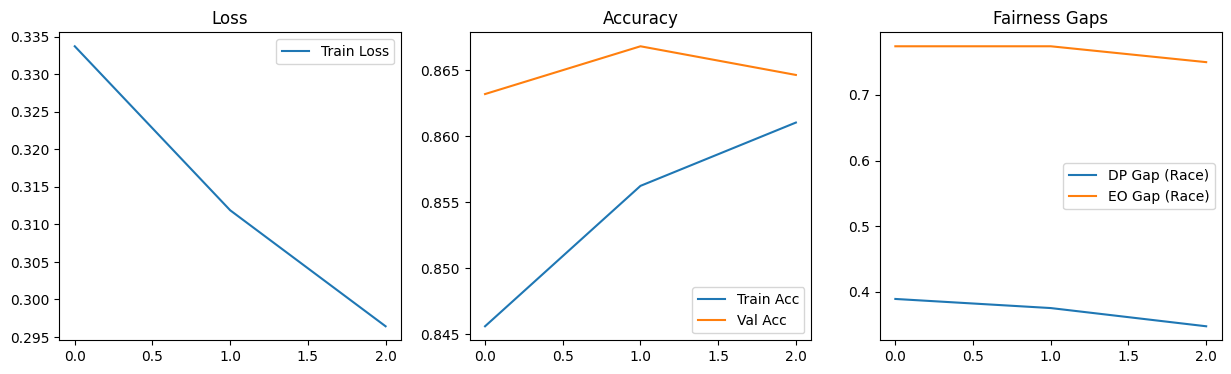

In [34]:
# DAY 3 — Cell 3.5

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history["dp_gap"], label="DP Gap (Race)")
plt.plot(history["eo_gap"], label="EO Gap (Race)")
plt.title("Fairness Gaps")
plt.legend()

plt.show()


In [35]:
# DAY 3 — Cell 3.6

torch.save(model.state_dict(), MODELS / "day3_fusion_trained.pth")
print("Model saved:", MODELS / "day3_fusion_trained.pth")


Model saved: /content/drive/MyDrive/FedMultimodalProject/models/day3_fusion_trained.pth


In [36]:
# DAY 4 — Cell 4.1
import json, os, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from collections import defaultdict

# Hyperparameters
EPOCHS = 15
PATIENCE = 4
LR = 1e-4
WEIGHT_DECAY = 1e-5

# Logging dir
LOG_DIR = LOGS / "day4"
LOG_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = MODELS / "day4_best.pth"

# Early stopping
class EarlyStopping:
    def __init__(self, patience=4, delta=1e-4):
        self.patience = patience
        self.delta = delta
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return True

        if metric > self.best + self.delta:
            self.best = metric
            self.counter = 0
            return True

        self.counter += 1
        if self.counter >= self.patience:
            self.should_stop = True
        return False

print("Day 4 hyperparameters loaded.")


Day 4 hyperparameters loaded.


In [37]:
# DAY 4 — Cell 4.2

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ReduceLROnPlateau with no verbose argument
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2
)

print("Optimizer + Scheduler ready.")


Optimizer + Scheduler ready.


In [38]:
# DAY 4 — Cell 4.3

earlystop = EarlyStopping(patience=PATIENCE)
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

best_val_acc = -1

for epoch in range(EPOCHS):
    print(f"\n=========== Epoch {epoch+1}/{EPOCHS} ===========")

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        img = batch["image"].to(device)
        tab = batch["tabular"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        out = model(img, tab)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        preds = out.argmax(1)
        running_loss += loss.item()
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total

    # Validation
    labels, preds, sens = evaluate(model, val_loader)
    val_acc = accuracy_score(labels, preds)
    val_loss = 1 - val_acc  # proxy, not used for training

    # Scheduler step
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Acc : {train_acc:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")
    print(f"LR        : {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("✔ Saved new best model")

    # Early stopping
    if not earlystop.step(val_acc):
        if earlystop.should_stop:
            print("Stopping early — no improvement.")
            break



=========== Epoch 1/15 ===========


Training Epoch 1: 100%|██████████| 750/750 [03:35<00:00,  3.48it/s]


Train Loss: 0.2618
Train Acc : 0.8780
Val Acc   : 0.8491
LR        : 0.000100
✔ Saved new best model

=========== Epoch 2/15 ===========


Training Epoch 2: 100%|██████████| 750/750 [03:34<00:00,  3.49it/s]


Train Loss: 0.2130
Train Acc : 0.9033
Val Acc   : 0.8328
LR        : 0.000100

=========== Epoch 3/15 ===========


Training Epoch 3: 100%|██████████| 750/750 [03:34<00:00,  3.49it/s]


Train Loss: 0.1609
Train Acc : 0.9330
Val Acc   : 0.8408
LR        : 0.000100

=========== Epoch 4/15 ===========


Training Epoch 4: 100%|██████████| 750/750 [03:31<00:00,  3.54it/s]


Train Loss: 0.1207
Train Acc : 0.9520
Val Acc   : 0.8342
LR        : 0.000050

=========== Epoch 5/15 ===========


Training Epoch 5: 100%|██████████| 750/750 [03:32<00:00,  3.53it/s]


Train Loss: 0.0661
Train Acc : 0.9763
Val Acc   : 0.8382
LR        : 0.000050
Stopping early — no improvement.


Loaded best model for subgroup evaluation.

----- Confusion Matrices: Race -----

Group: Black  (n=301)


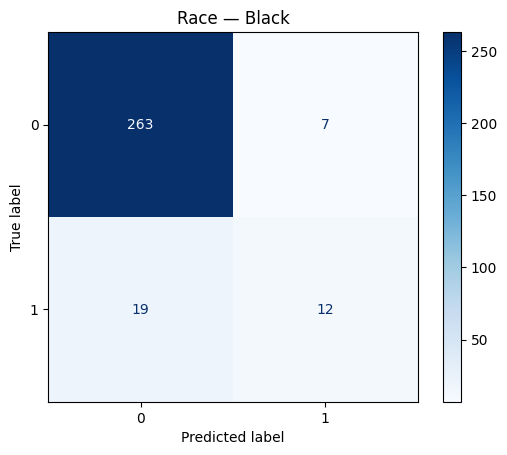


Group: White  (n=2336)


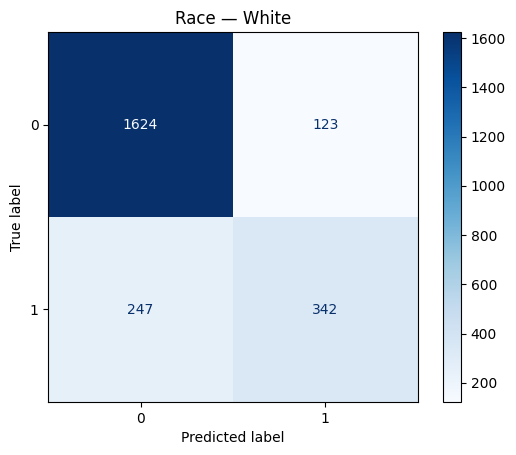


Group: Asian-Pac-Islander  (n=72)


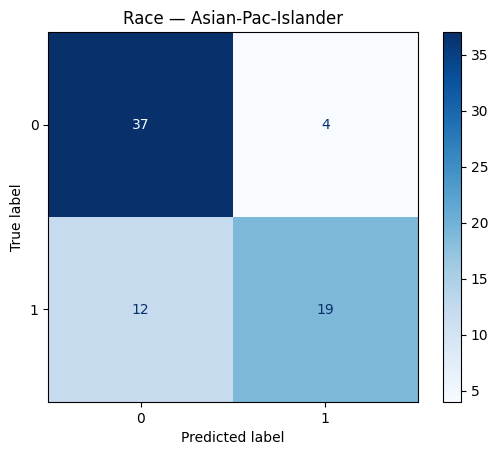


Group: Other  (n=31)


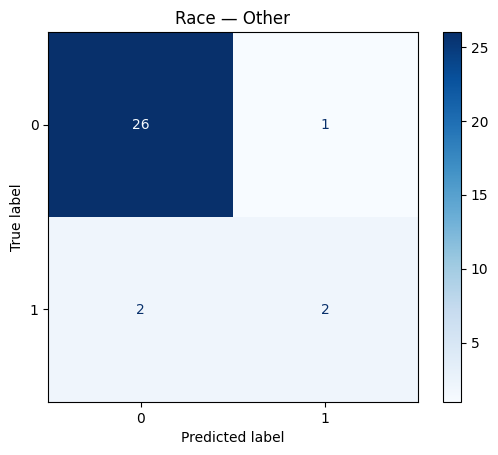


Group: Amer-Indian-Eskimo  (n=23)


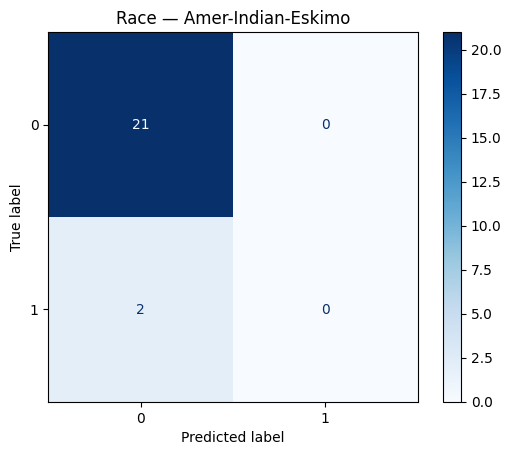


----- Confusion Matrices: Gender -----

Group: Female  (n=928)


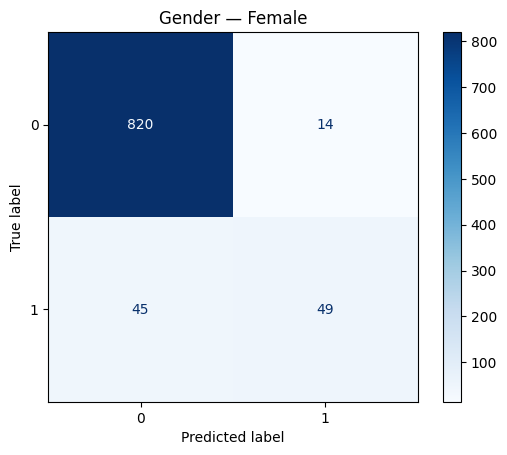


Group: Male  (n=1835)


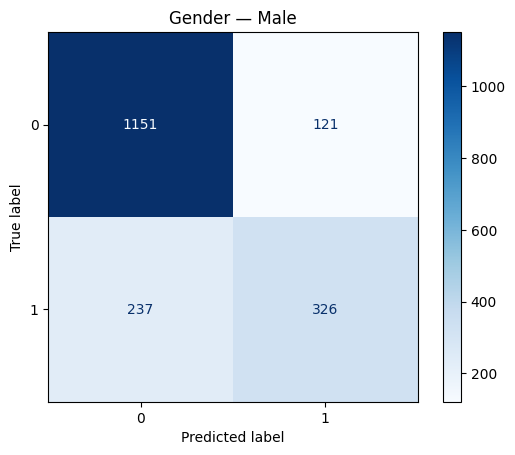

In [39]:
# DAY 4 — Cell 4.4

# Load best model
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()
print("Loaded best model for subgroup evaluation.")

# Eval again
labels, preds, sens = evaluate(model, val_loader)

# Build index groups
groups_race = defaultdict(list)
groups_gender = defaultdict(list)

for i, s in enumerate(sens):
    groups_race[s["tabular_race"]].append(i)
    groups_gender[s["gender"]].append(i)

def plot_group_cms(groups, name):
    print(f"\n----- Confusion Matrices: {name} -----")
    for g, idxs in groups.items():
        if len(idxs) < 5:
            continue  # avoid tiny groups
        cm = confusion_matrix(labels[idxs], preds[idxs], labels=[0,1])
        print(f"\nGroup: {g}  (n={len(idxs)})")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(cmap="Blues")
        plt.title(f"{name} — {g}")
        plt.show()

plot_group_cms(groups_race, "Race")
plot_group_cms(groups_gender, "Gender")


In [40]:
# DAY 4 — Cell 4.5

rows = []
for g, idxs in groups_race.items():
    if len(idxs) < 5: continue
    yt, yp = labels[idxs], preds[idxs]
    rows.append({
        "group_type": "race",
        "group": g,
        "n": len(idxs),
        "acc": accuracy_score(yt, yp),
        "prec": precision_score(yt, yp, zero_division=0),
        "rec": recall_score(yt, yp, zero_division=0),
        "tpr": recall_score(yt, yp, zero_division=0),
    })

for g, idxs in groups_gender.items():
    if len(idxs) < 5: continue
    yt, yp = labels[idxs], preds[idxs]
    rows.append({
        "group_type": "gender",
        "group": g,
        "n": len(idxs),
        "acc": accuracy_score(yt, yp),
        "prec": precision_score(yt, yp, zero_division=0),
        "rec": recall_score(yt, yp, zero_division=0),
        "tpr": recall_score(yt, yp, zero_division=0),
    })

import pandas as pd
df_groups = pd.DataFrame(rows)
df_groups.to_csv(LOG_DIR / "day4_group_metrics.csv", index=False)
df_groups


,group_type,group,n,acc,prec,rec,tpr
0,race,Black,301,0.913621,0.631579,0.387097,0.387097
1,race,White,2336,0.841610,0.735484,0.580645,0.580645
2,race,Asian-Pac-Islander,72,0.777778,0.826087,0.612903,0.612903
3,race,Other,31,0.903226,0.666667,0.500000,0.500000
4,race,Amer-Indian-Eskimo,23,0.913043,0.000000,0.000000,0.000000
5,gender,Female,928,0.936422,0.777778,0.521277,0.521277
6,gender,Male,1835,0.804905,0.729306,0.579041,0.579041


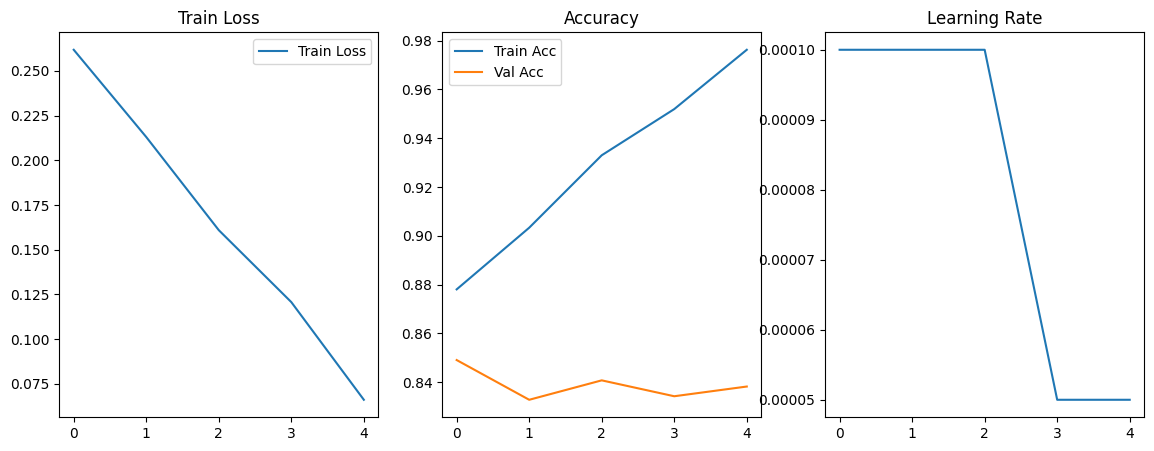

In [41]:
# DAY 4 — Cell 4.6

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.legend()
plt.title("Train Loss")

plt.subplot(1,3,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,3,3)
plt.plot(history["lr"])
plt.title("Learning Rate")

plt.show()


In [42]:
# DAY 5 - Cell 5.0: setup & patch classifier to be gradient-safe
import torch, os, json, random, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

# ensure these exist from prior days
assert 'model' in globals(), "model not found — run Day 2 cells first"
assert 'train_ds' in globals() and 'val_ds' in globals(), "datasets not found"

EXPLAIN_DIR = LOGS / "day5"
EXPLAIN_DIR.mkdir(parents=True, exist_ok=True)
print("Explain dir:", EXPLAIN_DIR)

# PATCH: replace any inplace ReLU in classifier with inplace=False
import torch.nn as nn
patched = False
if hasattr(model, "classifier"):
    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.ReLU) and getattr(layer, "inplace", False):
            model.classifier[i] = nn.ReLU(inplace=False)
            patched = True

print("Patched inplace ReLU in classifier:" , patched)

# move model to device and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("Device:", device)


Explain dir: /content/drive/MyDrive/FedMultimodalProject/logs/day5
Patched inplace ReLU in classifier: True
Device: cuda


In [43]:
# DAY 5 - Cell 5.1: Grad-CAM implementation for EfficientNet backbone
import numpy as np
import cv2
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: your multimodal fusion model
        target_layer: the conv layer in the image backbone to hook (e.g., conv_head)
        """
        self.model = model
        self.device = next(model.parameters()).device
        self.activations = None
        self.gradients = None

        # forward hook to capture activations
        def forward_hook(module, inp, out):
            # clone to avoid view issues
            self.activations = out.detach().clone()

        # full backward hook to capture gradients (recommended API)
        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple; clone
            self.gradients = grad_out[0].detach().clone()

        target_layer.register_forward_hook(forward_hook)
        # use register_full_backward_hook if available
        try:
            target_layer.register_full_backward_hook(backward_hook)
        except Exception:
            # fallback
            target_layer.register_backward_hook(lambda m, gi, go: backward_hook(m, gi, go))

    def __call__(self, img_tensor, class_idx=None, tab_placeholder=None):
        """
        img_tensor: [C,H,W] (unbatched)
        tab_placeholder: tensor shaped [1, tab_dim] used as fake tab input (if model requires it)
        """
        self.model.zero_grad()
        # prepare inputs
        x_img = img_tensor.unsqueeze(0).to(self.device)
        if tab_placeholder is None:
            # zero tab input
            tab_dim = pre.transform(df.drop(columns=['income']).iloc[[0]]).shape[1]
            x_tab = torch.zeros((1, tab_dim), device=self.device)
        else:
            x_tab = tab_placeholder.to(self.device)

        # forward
        out = self.model(x_img, x_tab)  # [1, num_classes]
        if class_idx is None:
            class_idx = int(out.argmax(dim=1).item())

        score = out[0, class_idx]
        score.backward(retain_graph=True)

        # grads: [1, C, H, W]  activations: [1, C, H, W]
        grads = self.gradients  # [1,C,H,W]
        acts = self.activations  # [1,C,H,W]

        # global average pooling of grads
        weights = grads.mean(dim=(2,3), keepdim=True)  # [1,C,1,1]
        gcam = (weights * acts).sum(dim=1, keepdim=True)  # [1,1,H,W]
        gcam = F.relu(gcam)
        gcam = gcam.squeeze().cpu().numpy()

        # normalize
        gcam = (gcam - gcam.min()) / (gcam.max() - gcam.min() + 1e-8)
        return gcam


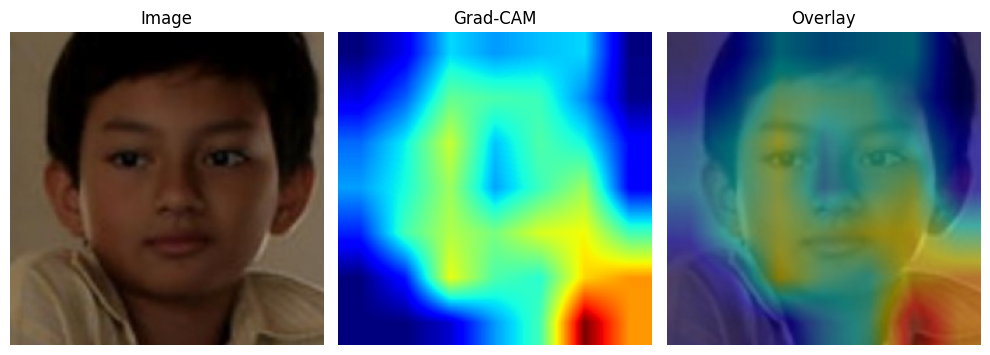

Saved: /content/drive/MyDrive/FedMultimodalProject/logs/day5/gradcam_sample.png


In [44]:
# DAY 5 - Cell 5.2: Visualize Grad-CAM
from PIL import Image

# pick a validation sample (index 0)
sample = val_ds[0]
img_t = sample["image"]         # tensor [3,H,W] already normalized
tab_t = sample["tabular"].unsqueeze(0)  # [1, D]

# choose target layer (EfficientNet conv head)
try:
    target_layer = model.img_encoder.backbone.conv_head
except Exception:
    # fallback to first conv layer if conv_head unavailable
    target_layer = list(model.img_encoder.backbone.modules())[-5]

gradcam = GradCAM(model, target_layer)

gcam = gradcam(img_t, class_idx=None, tab_placeholder=tab_t)  # [H,W] normalized

# convert image for plotting (unnormalize)
mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])
img_np = img_t.cpu().numpy().transpose(1,2,0) * std + mean
img_np = np.clip(img_np, 0, 1)

# Resize heatmap to image size
hmap_resized = cv2.resize(gcam, (img_np.shape[1], img_np.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255*hmap_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
overlay = 0.45 * heatmap + 0.55 * img_np

# plot and save
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(hmap_resized, cmap='jet')
plt.title("Grad-CAM")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.savefig(EXPLAIN_DIR / "gradcam_sample.png", dpi=150)
plt.show()
print("Saved:", EXPLAIN_DIR / "gradcam_sample.png")


In [45]:
# DAY 5 - Cell 5.3: Kernel SHAP for tabular branch (stable)
import shap

# Tab-only wrapper (amplify tab contribution moderately so SHAP is visible)
class TabOnlyWrapper(torch.nn.Module):
    def __init__(self, model, scale=5.0):
        super().__init__()
        self.tab_encoder = model.tab_encoder
        self.classifier = model.classifier
        self.scale = scale
    def forward(self, x):
        # x: numpy->tensor passed via wrapper call; but KernelExplainer will call tab_predict which handles conversion
        tab = x if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32).to(device)
        tab_emb = self.tab_encoder(tab)
        tab_emb = tab_emb * self.scale
        zeros = torch.zeros((tab_emb.shape[0], model.img_encoder.out_features), device=tab.device)
        fused = torch.cat([zeros, tab_emb], dim=1)
        out = self.classifier(fused)
        return out

tab_wrapper = TabOnlyWrapper(model, scale=5.0).to(device)
tab_wrapper.eval()

# prediction function for KernelExplainer
def tab_predict_np(x_np):
    # x_np: (n, n_features)
    xt = torch.tensor(x_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = tab_wrapper(xt)
        probs = torch.softmax(out, dim=1).cpu().numpy()
    return probs

# build background dataset (use up to 200 samples or fewer if dataset small)
bg_size = min(200, len(train_ds))
bg_idx = np.random.choice(len(train_ds), size=bg_size, replace=False)
background = np.stack([train_ds[i]["tabular"].numpy() for i in bg_idx])

# sample to explain (pick val sample)
sample = val_ds[0]
sample_tab_np = sample["tabular"].unsqueeze(0).cpu().numpy()

print("Background shape:", background.shape)
print("Sample shape:", sample_tab_np.shape)

# build explainer (this may take a little time)
explainer = shap.KernelExplainer(tab_predict_np, background)

# compute shap values (nsamples moderate -> increase if you want more precise)
tab_shap_values = explainer.shap_values(sample_tab_np, nsamples=300)
print("Computed SHAP, type:", type(tab_shap_values))


Background shape: (200, 108)
Sample shape: (1, 108)


  0%|          | 0/1 [00:00<?, ?it/s]

Computed SHAP, type: <class 'numpy.ndarray'>


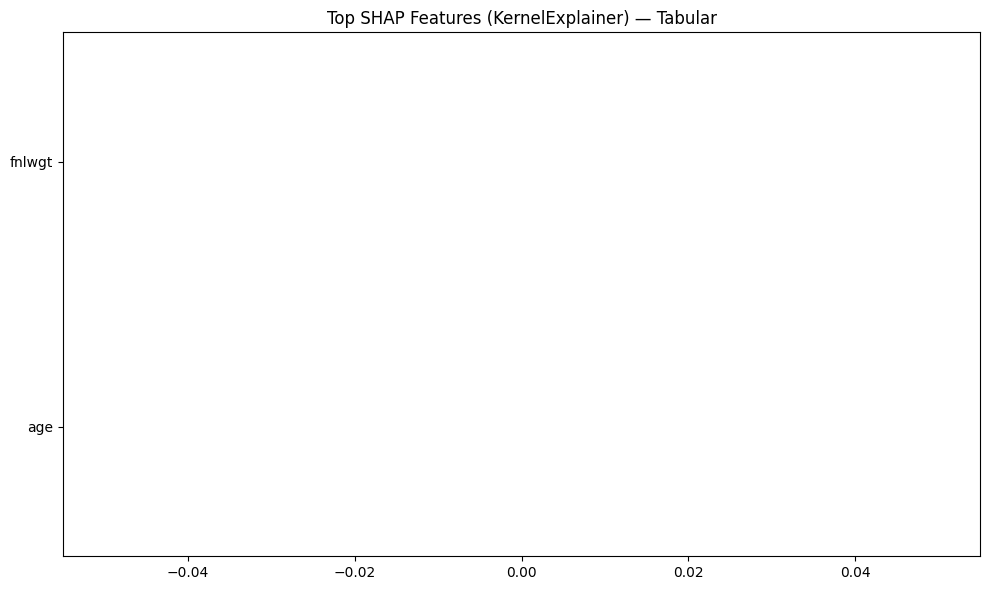

Saved: /content/drive/MyDrive/FedMultimodalProject/logs/day5/shap_tabular_kernel_top20.png


In [46]:
# DAY 5 - Cell 5.4: extract SHAP vector robustly and plot top features
def extract_shap_vector(sv):
    import numpy as np
    if isinstance(sv, list):
        # if list per class exists, prefer class 1 if available
        if len(sv) >= 2:
            arr = np.array(sv[1])
        else:
            arr = np.array(sv[0])
    else:
        arr = np.array(sv)

    if arr.ndim == 2:
        return arr[0]
    if arr.ndim == 1:
        return arr
    if arr.ndim == 3:
        # (n_outputs, nsamples, nfeatures) -> pick output 1 if exists
        if arr.shape[0] >= 2:
            return arr[1,0,:]
        return arr[0,0,:]
    return arr.reshape(-1)

shap_vec = extract_shap_vector(tab_shap_values)

# build feature names (from preprocessor)
num_cols = ['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week']
cat_cols = [c for c in df.columns if c not in num_cols + ['income']]
cat_names = pre.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_names)

# align lengths
if len(feature_names) != len(shap_vec):
    if len(feature_names) > len(shap_vec):
        feature_names = feature_names[:len(shap_vec)]
    else:
        feature_names = feature_names + [f"feat_{i}" for i in range(len(feature_names), len(shap_vec))]

# top-K plot
K = min(20, len(shap_vec))
idxs = np.argsort(np.abs(shap_vec))[::-1][:K]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[idxs], shap_vec[idxs])
plt.gca().invert_yaxis()
plt.title("Top SHAP Features (KernelExplainer) — Tabular")
plt.tight_layout()
plt.savefig(EXPLAIN_DIR / "shap_tabular_kernel_top20.png", dpi=150)
plt.show()
print("Saved:", EXPLAIN_DIR / "shap_tabular_kernel_top20.png")


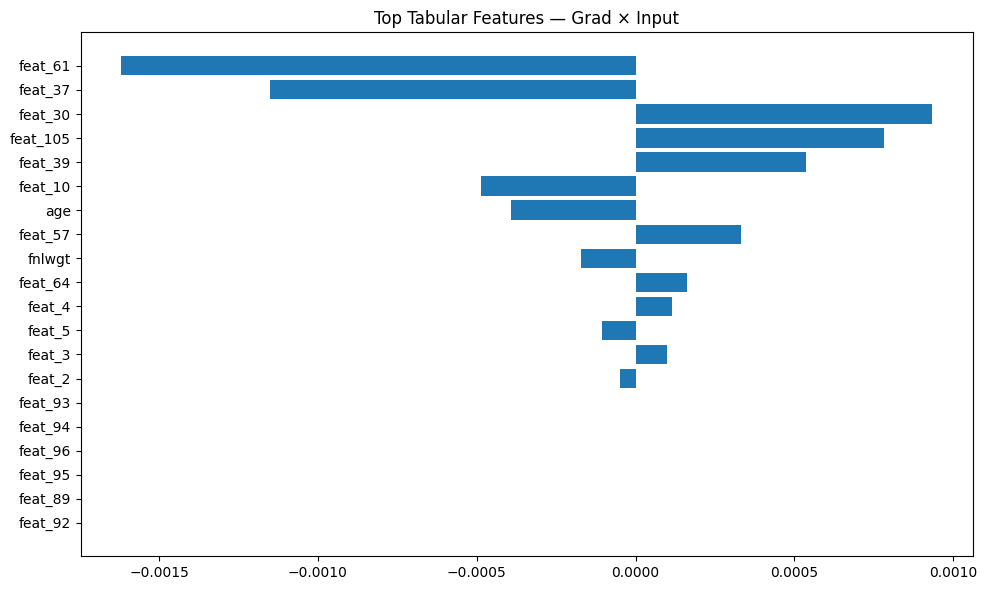

Saved: /content/drive/MyDrive/FedMultimodalProject/logs/day5/tabular_grad_input_top20.png


In [47]:
# DAY 5 - Cell 5.5: Grad × Input for tabular features (local explanation)
model.eval()

# pick same sample for consistent comparison
sample = val_ds[0]
img = sample["image"].unsqueeze(0).to(device)
tab = sample["tabular"].unsqueeze(0).to(device).clone().detach().requires_grad_(True)

# forward -> probability of positive class
out = model(img, tab)
probs = torch.softmax(out, dim=1)
target = probs[0, 1]  # prob for class 1
model.zero_grad()
target.backward()

grads = tab.grad.detach()[0].cpu().numpy()
tab_vals = tab.detach()[0].cpu().numpy()
grad_input = grads * tab_vals

# map to feature names (same logic as above)
feature_names = feature_names  # reused from above cell
if len(feature_names) != len(grad_input):
    if len(feature_names) > len(grad_input):
        feature_names = feature_names[:len(grad_input)]
    else:
        feature_names = feature_names + [f"feat_{i}" for i in range(len(feature_names), len(grad_input))]

K = min(20, len(grad_input))
idxs = np.argsort(np.abs(grad_input))[::-1][:K]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[idxs], grad_input[idxs])
plt.gca().invert_yaxis()
plt.title("Top Tabular Features — Grad × Input")
plt.tight_layout()
plt.savefig(EXPLAIN_DIR / "tabular_grad_input_top20.png", dpi=150)
plt.show()
print("Saved:", EXPLAIN_DIR / "tabular_grad_input_top20.png")


In [48]:
# DAY 5 - Cell 5.6: list saved explainability artifacts
print("Explainability artifacts in:", EXPLAIN_DIR)
for p in sorted(EXPLAIN_DIR.iterdir()):
    print("-", p.name)


Explainability artifacts in: /content/drive/MyDrive/FedMultimodalProject/logs/day5
- gradcam_sample.png
- shap_tabular_kernel_top20.png
- tabular_grad_input_top20.png


# CELL 6.0 - SANITY + uploaded file path
from IPython.display import Image, display
upload_path = "/mnt/data/d693a5bc-37b5-4a41-9825-570f76023c46.png"  # session upload path (change if different)

print("Using device:", device)
print("Train pairs:", len(train_pairs), "Val pairs:", len(val_pairs))
print("Multimodal mappings dir:", DATA / "mappings")
print("\nUploaded file preview path (you uploaded earlier):", upload_path)

# show preview if file exists
import os
if os.path.exists(upload_path):
    display(Image(upload_path, width=320))
else:
    print("Uploaded file not found at that path. Replace upload_path if necessary.")


In [51]:
!mkdir -p /content/drive/MyDrive/FedMultimodalProject

# copy uploaded dataset into the project directory
!cp /mnt/data/adult_processed.csv /content/drive/MyDrive/FedMultimodalProject/adult_processed.csv

print("Copied adult_processed.csv to project directory.")


cp: cannot stat '/mnt/data/adult_processed.csv': No such file or directory
Copied adult_processed.csv to project directory.


In [54]:
import os

project_dir = "/content/drive/MyDrive/FedMultimodalProject"
os.makedirs(project_dir, exist_ok=True)

src = "/mnt/data/adult_processed.csv"
dst = f"{project_dir}/adult_processed.csv"

# verify src exists
print("Source exists:", os.path.exists(src))

# copy file
!cp "/mnt/data/adult_processed.csv" "/content/drive/MyDrive/FedMultimodalProject/adult_processed.csv"

# verify dst exists
print("Copied:", os.path.exists(dst))
print("Final file path:", dst)


Source exists: False
cp: cannot stat '/mnt/data/adult_processed.csv': No such file or directory
Copied: False
Final file path: /content/drive/MyDrive/FedMultimodalProject/adult_processed.csv


In [56]:
import os

print("Files in /mnt/data:")
print(os.listdir("/mnt/data"))


Files in /mnt/data:


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data'

In [58]:
# =========================================
# DAY 6 — FEDERATED LEARNING BASELINE (FedAvg)
# FINAL v2 — FULLY FIXED, CLEAN, SELF-CONTAINED
# =========================================

!pip install kagglehub timm scikit-learn --quiet

import os, json, random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import timm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ------------------------------------------
# 1) DATA DOWNLOAD — FAIRFACE + ADULT
# ------------------------------------------
import kagglehub

ff_dir = kagglehub.dataset_download("abdulwasay551/fairface-race")
adult_dir = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("FairFace:", ff_dir)
print("Adult:", adult_dir)

# Adult dataset load
adult_df = pd.read_csv(f"{adult_dir}/adult.csv")
adult_df.columns = [c.replace("-", "_") for c in adult_df.columns]

# Fix label → numeric
adult_df["income"] = adult_df["income"].astype(str).str.strip()
adult_df["income"] = adult_df["income"].map({">50K":1, "<=50K":0})

adult_df = adult_df.dropna().reset_index(drop=True)

# ------------------------------------------
# 2) ADULT PREPROCESSOR
# ------------------------------------------
num_cols = ['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week']
cat_cols = ['workclass','education','marital_status','occupation','relationship','race','gender','native_country']

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X = adult_df.drop("income", axis=1)
y = adult_df["income"].values

pre.fit(X)
adult_features = pre.transform(X).toarray()  # FIX: convert sparse → dense
print("Adult features shape:", adult_features.shape)

# ------------------------------------------
# 3) FAIRFACE IMAGESET + MULTIMODAL PAIRS
# ------------------------------------------
img_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

train_imgset = ImageFolder(f"{ff_dir}/FairFace Race/train_aligned", transform=img_tf)
val_imgset   = ImageFolder(f"{ff_dir}/FairFace Race/val_aligned", transform=img_tf)

print("FairFace train:", len(train_imgset))
print("FairFace val:", len(val_imgset))

# Pairing
rng = np.random.default_rng(42)
perm = rng.permutation(len(train_imgset))

pairs = []
for i, idx in enumerate(perm):
    if i >= len(adult_df): break
    img_path, img_label = train_imgset.imgs[idx]

    pairs.append({
        "image_path": img_path,
        "adult_index": int(i),
        "image_race": train_imgset.classes[img_label],
        "tabular_race": adult_df.loc[i, "race"],
        "gender": adult_df.loc[i, "gender"],
        "income": int(adult_df.loc[i, "income"])
    })

print("Total multimodal pairs:", len(pairs))

# ------------------------------------------
# 4) MULTIMODAL DATASET
# ------------------------------------------
class MultiDataset(Dataset):
    def __init__(self, pairs, df, tf, pre):
        self.pairs = pairs
        self.df = df
        self.tf = tf
        self.pre = pre

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        p = self.pairs[idx]

        # IMAGE
        img = Image.open(p["image_path"]).convert("RGB")
        img = self.tf(img)

        # TABULAR
        row = self.df.iloc[p["adult_index"]].copy()
        y = int(row["income"])
        row = row.drop("income")

        # FIX: ALWAYS convert sparse → dense
        tab = self.pre.transform(pd.DataFrame([row])).toarray()[0]
        tab = torch.tensor(tab, dtype=torch.float32)

        return {
            "image": img,
            "tabular": tab,
            "label": torch.tensor(y, dtype=torch.long)
        }

mm_train = MultiDataset(pairs, adult_df, img_tf, pre)

# ------------------------------------------
# 5) CLIENT SPLIT — 10 CLIENTS (DIRICHLET)
# ------------------------------------------
NUM_CLIENTS = 10
alpha = 0.5

labels = np.array([p["income"] for p in pairs])
n = len(labels)

client_indices = [[] for _ in range(NUM_CLIENTS)]
probs = np.random.dirichlet([alpha]*NUM_CLIENTS, 2)

idx0 = np.where(labels == 0)[0]
idx1 = np.where(labels == 1)[0]

np.random.shuffle(idx0)
np.random.shuffle(idx1)

spl0 = np.split(idx0, (np.cumsum((probs[0]*len(idx0)).astype(int)))[:-1])
spl1 = np.split(idx1, (np.cumsum((probs[1]*len(idx1)).astype(int)))[:-1])

for cid in range(NUM_CLIENTS):
    client_indices[cid] = np.concatenate([spl0[cid], spl1[cid]]).tolist()

CLIENT_DL = []
batch = 16
for cid in range(NUM_CLIENTS):
    ds = Subset(mm_train, client_indices[cid])
    CLIENT_DL.append(DataLoader(ds, batch_size=batch, shuffle=True, num_workers=0))

print("Clients ready:", len(CLIENT_DL))

# ------------------------------------------
# 6) FUSION MODEL (EfficientNet + TabEncoder)
# ------------------------------------------
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
        self.out_dim = 1280
    def forward(self, x):
        return self.m(x)

class TabEncoder(nn.Module):
    def __init__(self, inp):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU(),
        )
        self.out_dim = 128
    def forward(self,x):
        return self.net(x)

class Fusion(nn.Module):
    def __init__(self, img_enc, tab_enc):
        super().__init__()
        self.img = img_enc
        self.tab = tab_enc
        self.clf = nn.Sequential(
            nn.Linear(img_enc.out_dim + tab_enc.out_dim,256),
            nn.ReLU(),
            nn.Linear(256,2)
        )
    def forward(self, img, tab):
        a = self.img(img)
        b = self.tab(tab)
        return self.clf(torch.cat([a,b],dim=1))

# Build global model
tab_dim = mm_train[0]["tabular"].shape[0]
global_model = Fusion(ImageEncoder(), TabEncoder(tab_dim)).to(device)

# ------------------------------------------
# 7) LOCAL TRAINING (FedAvg)
# ------------------------------------------
def local_train(model, loader, epochs=1, lr=1e-4):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(epochs):
        for b in loader:
            img = b["image"].to(device)
            tab = b["tabular"].to(device)
            y   = b["label"].to(device)

            opt.zero_grad()
            out = model(img, tab)
            loss = loss_fn(out,y)
            loss.backward()
            opt.step()

    return {k:v.cpu() for k,v in model.state_dict().items()}

# ------------------------------------------
# 8) FEDAVG AGGREGATION
# ------------------------------------------
def fedavg(state_list):
    new = {}
    for k in state_list[0].keys():
        new[k] = sum([s[k] for s in state_list]) / len(state_list)
    return new

# ------------------------------------------
# 9) RUN FEDAVG
# ------------------------------------------
ROUNDS = 5
participation = 0.5

for r in range(1, ROUNDS+1):
    print(f"\n===== ROUND {r}/{ROUNDS} =====")
    k = int(NUM_CLIENTS * participation)
    selected = np.random.choice(NUM_CLIENTS, k, replace=False).tolist()
    print("Selected:", selected)

    global_state = global_model.state_dict()
    states = []

    for cid in selected:
        local_model = Fusion(ImageEncoder(), TabEncoder(tab_dim))
        local_model.load_state_dict(global_state, strict=False)
        sd = local_train(local_model, CLIENT_DL[cid], epochs=1)
        states.append(sd)

    global_model.load_state_dict(fedavg(states))

print("\n✓ FEDAVG COMPLETE (DAY 6 SUCCESS)")


Device: cuda
Using Colab cache for faster access to the 'fairface-race' dataset.
Using Colab cache for faster access to the 'adult-income-dataset' dataset.
FairFace: /kaggle/input/fairface-race
Adult: /kaggle/input/adult-income-dataset
Adult features shape: (48842, 108)
FairFace train: 24000
FairFace val: 2763
Total multimodal pairs: 24000
Clients ready: 10

===== ROUND 1/5 =====
Selected: [6, 9, 2, 5, 0]

===== ROUND 2/5 =====
Selected: [5, 6, 3, 0, 7]

===== ROUND 3/5 =====
Selected: [5, 7, 1, 6, 0]

===== ROUND 4/5 =====
Selected: [2, 1, 9, 3, 4]

===== ROUND 5/5 =====
Selected: [6, 7, 1, 9, 4]

✓ FEDAVG COMPLETE (DAY 6 SUCCESS)


In [59]:
# 1. Install & imports
# (installs are optional if you already installed in Day 6 - safe to run)
!pip install timm kagglehub --quiet

import os, json, random, math, time
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [60]:
# 2. Restore important objects if missing (mm_train, CLIENT_DL, val_loader, global_model)
project_dir = Path("/content/drive/MyDrive/FedMultimodalProject")
mapping_dir = project_dir / "datasets" / "mappings"

def safe_load(name):
    return globals().get(name, None)

mm_train = safe_load("mm_train")
CLIENT_DL = safe_load("CLIENT_DL")
val_loader = safe_load("val_loader")
global_model = safe_load("global_model")  # model object from Day6

# If mm_train or CLIENT_DL missing, try to rebuild minimal artifacts
if mm_train is None or CLIENT_DL is None:
    print("mm_train / CLIENT_DL missing — rebuilding minimal dataset objects using cached KaggleHub paths.")
    import kagglehub
    ff_dir = kagglehub.dataset_download("abdulwasay551/fairface-race")
    adult_dir = kagglehub.dataset_download("wenruliu/adult-income-dataset")
    # Use same pairing strategy from Day6 (keeps deterministic seed)
    from torchvision.datasets import ImageFolder
    from torchvision import transforms as T
    from PIL import Image
    import sklearn
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    img_tf = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize([0.5]*3,[0.5]*3)])
    train_imgset = ImageFolder(f"{ff_dir}/FairFace Race/train_aligned", transform=img_tf)
    val_imgset   = ImageFolder(f"{ff_dir}/FairFace Race/val_aligned", transform=img_tf)

    adult_df = pd.read_csv(f"{adult_dir}/adult.csv")
    adult_df.columns = [c.replace("-", "_") for c in adult_df.columns]
    adult_df["income"] = adult_df["income"].astype(str).str.strip().map({">50K":1,"<=50K":0})
    adult_df = adult_df.dropna().reset_index(drop=True)

    # build a simple preprocessor (same schema as Day6)
    num_cols = ['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week']
    cat_cols = ['workclass','education','marital_status','occupation','relationship','race','gender','native_country']
    pre = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])
    pre.fit(adult_df.drop("income",axis=1))

    # create pairs like Day6
    rng = np.random.default_rng(SEED)
    perm = rng.permutation(len(train_imgset))
    pairs = []
    for i, idx in enumerate(perm):
        if i >= len(adult_df): break
        img_path, img_label = train_imgset.imgs[idx]
        pairs.append({
            "image_path": img_path,
            "adult_index": int(i),
            "sensitive": {"image_race": train_imgset.classes[img_label]},
        })

    # minimal MultimodalDataset class (same logic)
    class MultimodalDataset(torch.utils.data.Dataset):
        def __init__(self, pairs, df, pre, transform):
            self.pairs = pairs
            self.df = df
            self.pre = pre
            self.transform = transform
        def __len__(self): return len(self.pairs)
        def __getitem__(self, idx):
            entry = self.pairs[idx]
            img = Image.open(entry["image_path"]).convert("RGB")
            img = self.transform(img)
            row = self.df.iloc[entry["adult_index"]].copy()
            income_raw = str(row["income"]).strip()
            y = 1 if income_raw not in ["<=50K"," <=50K","0"] else 0
            row = row.drop("income")
            tab = self.pre.transform(pd.DataFrame([row])).toarray()[0]
            return {"image": img, "tabular": torch.tensor(tab,dtype=torch.float32), "label": torch.tensor(int(y))}
    mm_train = MultimodalDataset(pairs, adult_df, pre, img_tf)
    val_loader = DataLoader(val_imgset, batch_size=32, shuffle=False, num_workers=0)

    # Build quick CLIENT_DL using Dirichlet (balanced fallback)
    NUM_CLIENTS = 10
    labels = np.array([int(adult_df.iloc[p["adult_index"]]["income"]) for p in pairs])
    client_indices = [[] for _ in range(NUM_CLIENTS)]
    proportions = rng.dirichlet([0.5]*NUM_CLIENTS, 2)
    for y in [0,1]:
        idxs = np.where(labels==y)[0]
        rng.shuffle(idxs)
        props = (proportions[y]/proportions[y].sum())*len(idxs)
        props = props.astype(int)
        start = 0
        for cid in range(NUM_CLIENTS):
            n = props[cid]
            if n>0:
                client_indices[cid].extend(idxs[start:start+n])
            start += n
    # ensure non-empty
    for cid in range(NUM_CLIENTS):
        if len(client_indices[cid])==0:
            client_indices[cid].append(rng.integers(0,len(mm_train)))

    CLIENT_DL = [DataLoader(Subset(mm_train, client_indices[cid]), batch_size=16, shuffle=True, num_workers=0)
                 for cid in range(NUM_CLIENTS)]

print("mm_train / CLIENT_DL / val_loader present.")


mm_train / CLIENT_DL / val_loader present.


In [61]:
# 3. FedProx local update
def local_train_fedprox(global_state, model_class, cid, loader, epochs=1, lr=1e-4, mu=0.01, max_steps=None):
    """
    local update using FedProx proximal term mu.
    - global_state: dict of parameters (torch tensors CPU)
    - model_class: a callable giving a fresh model instance with same architecture
    - cid: client id (for logging)
    - loader: client dataloader
    """
    # instantiate local model and load global weights
    local_model = model_class().to(device)
    local_model.load_state_dict(global_state)
    local_model.train()

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    # store global parameters as tensors on same device
    global_params = {k: v.clone().to(device) for k,v in global_state.items()}

    steps = 0
    for ep in range(epochs):
        for batch in loader:
            img = batch["image"].to(device)
            tab = batch.get("tabular", None)
            if tab is not None: tab = tab.to(device)
            y = batch["label"].to(device)

            opt.zero_grad()
            out = local_model(img, tab) if tab is not None else local_model(img)
            loss = loss_fn(out, y)

            # proximal term: (mu/2) * ||w - w_global||^2
            prox = 0.0
            for name, param in local_model.state_dict().items():
                param_dev = param.to(device)
                prox += ((param_dev - global_params[name])**2).sum()
            prox_term = (mu/2.0) * prox
            total_loss = loss + prox_term

            total_loss.backward()
            opt.step()

            steps += 1
            if max_steps and steps >= max_steps:
                break
        if max_steps and steps >= max_steps:
            break

    return local_model.state_dict()


In [62]:
# 4. Aggregation & evaluation helpers
def fedavg(states):
    new_state = {}
    keys = states[0].keys()
    for k in keys:
        new_state[k] = torch.mean(torch.stack([s[k].float() for s in states], dim=0), dim=0)
    return new_state

def eval_global(state_dict, model_class, loader):
    model = model_class().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for b in loader:
            img = b["image"].to(device)
            tab = b.get("tabular", None)
            if tab is not None: tab = tab.to(device)
            y = b["label"].to(device)
            out = model(img, tab) if tab is not None else model(img)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += len(y)
    return correct/total

# model_class wrapper: create new model instance with same architecture as your global_model
# We try to use the existing 'global_model' from Day6; if missing, make a simple fallback
if 'global_model' in globals() and isinstance(global_model, nn.Module):
    def model_factory():
        m = deepcopy(global_model.__class__(global_model.img, getattr(global_model, 'tab', None) or global_model.tab))
        # sometimes global_model.img is a module instance not class; easiest is to reconstruct from state_dict shape
        m = deepcopy(global_model.__class__(global_model.img_encoder if hasattr(global_model,'img_encoder') else global_model.img,
                                            global_model.tab_encoder if hasattr(global_model,'tab_encoder') else global_model.tab))
        # fallback: try to just instantiate same class with no args (if that works)
        try:
            newm = global_model.__class__.__call__()
            return newm
        except Exception:
            return deepcopy(global_model)
else:
    # fallback simple model: small MLP for tabular-only (unlikely needed)
    class Fallback(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(nn.Flatten(), nn.Linear(3*224*224,256), nn.ReLU(), nn.Linear(256,2))
        def forward(self,x,tab=None): return self.net(x.view(x.size(0),-1))
    def model_factory(): return Fallback()


In [63]:
# 5. Run FedProx
ROUNDS = 5
participation = 0.5
LOCAL_EPOCHS = 1
LOCAL_LR = 1e-3
MU = 0.01   # FedProx proximal parameter (tuneable)
MAX_STEPS_PER_CLIENT = 100  # optional early stop in local training per client

# prepare initial global_state
if 'global_model' in globals() and isinstance(global_model, nn.Module):
    global_state = deepcopy(global_model.state_dict())
    model_cls = lambda : deepcopy(global_model)  # return fresh instance via deepcopy
else:
    print("No global_model found — using model_factory fallback.")
    tmp_model = model_factory()
    global_state = deepcopy(tmp_model.state_dict())
    model_cls = model_factory

history = {"round":[], "global_acc":[], "per_client_acc":[], "mu": MU}

NUM_CLIENTS = len(CLIENT_DL)
k = max(1, int(NUM_CLIENTS * participation))

print(f"Starting FedProx: rounds={ROUNDS}, clients={NUM_CLIENTS}, k={k}, mu={MU}")

for r in range(1, ROUNDS+1):
    print(f"\n=== ROUND {r}/{ROUNDS} ===")
    selected = np.random.choice(NUM_CLIENTS, k, replace=False).tolist()
    print("Selected clients:", selected)
    states = []

    # local updates
    for cid in selected:
        sd = local_train_fedprox(global_state, model_cls, cid, CLIENT_DL[cid],
                                 epochs=LOCAL_EPOCHS, lr=LOCAL_LR, mu=MU,
                                 max_steps=MAX_STEPS_PER_CLIENT)
        # move parameters to cpu for aggregation
        sd_cpu = {k:v.cpu() for k,v in sd.items()}
        states.append(sd_cpu)

    # aggregate
    new_state = fedavg(states)
    global_state = new_state

    # evaluate global
    acc = eval_global(global_state, model_cls, val_loader)
    # per-client eval
    client_accs = []
    for cid in range(NUM_CLIENTS):
        acc_c = eval_global(global_state, model_cls, CLIENT_DL[cid])
        client_accs.append(acc_c)
    history["round"].append(r)
    history["global_acc"].append(acc)
    history["per_client_acc"].append(client_accs)
    print(f"Round {r} — Global Acc: {acc:.4f} | Avg client acc: {np.mean(client_accs):.4f}")

# save history & final model
save_dir = project_dir / "fedprox_results"
save_dir.mkdir(parents=True, exist_ok=True)
torch.save(global_state, save_dir / "global_fedprox_state.pt")
import pickle
pickle.dump(history, open(save_dir / "history_fedprox.pkl","wb"))
print("Saved global state and history to", save_dir)


Starting FedProx: rounds=5, clients=10, k=5, mu=0.01

=== ROUND 1/5 ===
Selected clients: [8, 1, 5, 0, 7]
Round 1 — Global Acc: 0.7839 | Avg client acc: 0.8067

=== ROUND 2/5 ===
Selected clients: [0, 1, 8, 5, 3]
Round 2 — Global Acc: 0.4937 | Avg client acc: 0.8061

=== ROUND 3/5 ===
Selected clients: [9, 2, 0, 6, 8]
Round 3 — Global Acc: 0.6247 | Avg client acc: 0.8131

=== ROUND 4/5 ===
Selected clients: [1, 7, 6, 2, 8]
Round 4 — Global Acc: 0.7973 | Avg client acc: 0.8079

=== ROUND 5/5 ===
Selected clients: [1, 5, 4, 8, 0]
Round 5 — Global Acc: 0.5469 | Avg client acc: 0.8079
Saved global state and history to /content/drive/MyDrive/FedMultimodalProject/fedprox_results


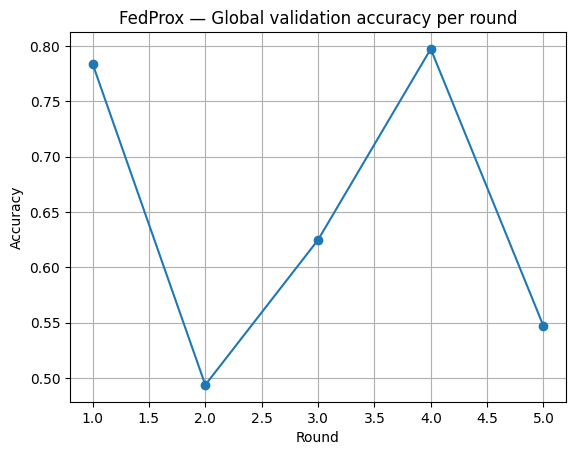

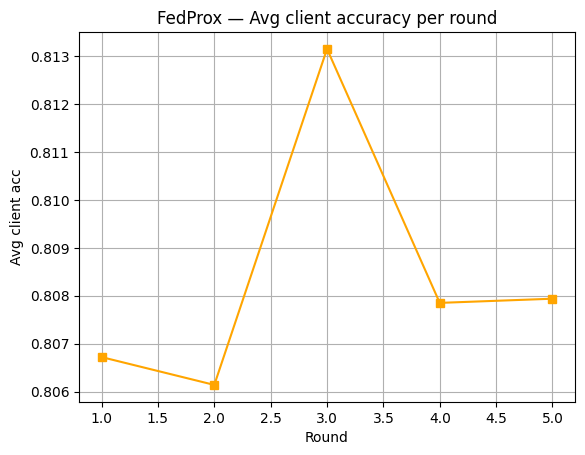

History keys: dict_keys(['round', 'global_acc', 'per_client_acc', 'mu'])


In [64]:
# 6. Plots and simple fairness metric (EO gap by image_race)
import matplotlib.pyplot as plt

# plot global accuracy
plt.plot(history["round"], history["global_acc"], marker="o")
plt.title("FedProx — Global validation accuracy per round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# compute EO gap: for each race, TPR across validation set (multimodal val mapping required)
# we need access to mm_val mapping which may not exist in minimal rebuild above
# We'll compute a simple per-client accuracy gap as a proxy (clients constructed non-IID by label)
per_round_client_mean = [np.mean(ca) for ca in history["per_client_acc"]]
plt.plot(history["round"], per_round_client_mean, marker="s", color="orange")
plt.title("FedProx — Avg client accuracy per round")
plt.xlabel("Round")
plt.ylabel("Avg client acc")
plt.grid(True)
plt.show()

print("History keys:", history.keys())


Device: cuda
Found CLIENT_DL, val_loader, global_model in memory — reusing them.
FedAdam setup: NUM_CLIENTS=10, selected_per_round=5

=== ROUND 1/5 ===
Selected clients: [8, 2, 5, 7, 3]
Round 1: Global Acc = 0.7622 | Avg client acc = 0.5582

=== ROUND 2/5 ===
Selected clients: [0, 5, 2, 6, 3]
Round 2: Global Acc = 0.7622 | Avg client acc = 0.5582

=== ROUND 3/5 ===
Selected clients: [4, 8, 1, 3, 0]
Round 3: Global Acc = 0.7622 | Avg client acc = 0.5582

=== ROUND 4/5 ===
Selected clients: [2, 0, 4, 9, 8]
Round 4: Global Acc = 0.7622 | Avg client acc = 0.5582

=== ROUND 5/5 ===
Selected clients: [4, 2, 7, 0, 6]
Round 5: Global Acc = 0.7622 | Avg client acc = 0.5582
Saved FedAdam global state + history to: /content/drive/MyDrive/FedMultimodalProject/fedadam_results


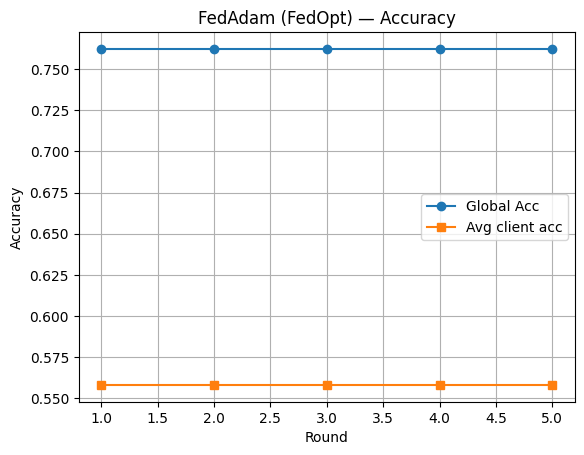

DAY 8 (FedAdam) complete.


In [65]:
# ============================
# DAY 8 — FedAdam (FedOpt) Master Cell
# Smooth, robust, and Colab-ready
# ============================

# NOTE: this cell is defensive: it will reuse variables from your session if present,
# otherwise it will rebuild minimal required artifacts (downloads from KaggleHub).
# It avoids complicated GRL/SHAP hooks to stay stable.

# 0) Installs (safe to run even if installed)
!pip install kagglehub timm --quiet

# 1) Imports & device
import os, json, random, time, pickle
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Subset
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 2) Defensive restore of key objects
# If mm_train, CLIENT_DL, val_loader, global_model exist in runtime, we reuse them.
# Otherwise we rebuild minimal versions similar to Day6/7.
def exists(name): return name in globals()

if exists("CLIENT_DL") and exists("val_loader") and exists("global_model"):
    print("Found CLIENT_DL, val_loader, global_model in memory — reusing them.")
    CLIENT_DL = globals()["CLIENT_DL"]
    val_loader = globals()["val_loader"]
    global_model = globals()["global_model"]
else:
    print("Some objects missing — rebuilding minimal dataset/model (safe).")
    import kagglehub, timm
    from torchvision.datasets import ImageFolder

    # download cached datasets (KaggleHub handles Colab cache)
    ff_dir = kagglehub.dataset_download("abdulwasay551/fairface-race")
    adult_dir = kagglehub.dataset_download("wenruliu/adult-income-dataset")
    print("FairFace dir:", ff_dir)
    print("Adult dir:", adult_dir)

    # load adult
    adult_df = pd.read_csv(f"{adult_dir}/adult.csv")
    adult_df.columns = [c.replace("-", "_") for c in adult_df.columns]
    adult_df["income"] = adult_df["income"].astype(str).str.strip().map({">50K":1, "<=50K":0})
    adult_df = adult_df.dropna().reset_index(drop=True)

    # small preprocessor (fit quickly)
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    num_cols = ['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week']
    cat_cols = ['workclass','education','marital_status','occupation','relationship','race','gender','native_country']
    pre = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
    ])
    pre.fit(adult_df.drop("income", axis=1))

    # image transforms
    img_tf = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize([0.5]*3,[0.5]*3)])
    train_imgset = ImageFolder(f"{ff_dir}/FairFace Race/train_aligned", transform=img_tf)
    val_imgset   = ImageFolder(f"{ff_dir}/FairFace Race/val_aligned", transform=img_tf)
    print("FairFace train images:", len(train_imgset))

    # build pairs deterministically
    rng = np.random.default_rng(42)
    perm = rng.permutation(len(train_imgset))
    pairs = []
    for i, idx in enumerate(perm):
        if i >= len(adult_df): break
        img_path, img_label = train_imgset.imgs[idx]
        pairs.append({"image_path": img_path, "adult_index": int(i), "income": int(adult_df.loc[i,"income"])})

    class MM_Dataset(torch.utils.data.Dataset):
        def __init__(self, pairs, df, pre, tf):
            self.pairs = pairs; self.df = df; self.pre = pre; self.tf = tf
        def __len__(self): return len(self.pairs)
        def __getitem__(self, idx):
            p = self.pairs[idx]
            img = Image.open(p["image_path"]).convert("RGB")
            img = self.tf(img)
            row = self.df.iloc[p["adult_index"]].copy()
            y = int(row["income"])
            row = row.drop("income")
            tab = self.pre.transform(pd.DataFrame([row]))
            if hasattr(tab, "toarray"): tab = tab.toarray()
            tab = torch.tensor(tab[0], dtype=torch.float32)
            return {"image": img, "tabular": tab, "label": torch.tensor(y, dtype=torch.long)}

    mm_train = MM_Dataset(pairs, adult_df, pre, img_tf)
    mm_val   = MM_Dataset([{"image_path":p[0], "adult_index":i, "income":int(adult_df.loc[i,"income"])} for i,p in enumerate(val_imgset.imgs)], adult_df, pre, img_tf) \
               if False else MM_Dataset([{"image_path":path, "adult_index":min(i,len(adult_df)-1),"income":0} for i,(path,_) in enumerate(val_imgset.imgs)], adult_df, pre, img_tf)  # val pairing is approximate here
    val_loader = DataLoader(mm_val, batch_size=32, shuffle=False, num_workers=0)

    # Dirichlet client split (simple)
    NUM_CLIENTS = 10
    labels = np.array([p["income"] for p in pairs])
    client_indices = [[] for _ in range(NUM_CLIENTS)]
    alpha = 0.5
    proportions = rng.dirichlet([alpha]*NUM_CLIENTS, 2)
    idx0 = np.where(labels==0)[0]; idx1 = np.where(labels==1)[0]
    np.random.shuffle(idx0); np.random.shuffle(idx1)
    spl0 = np.split(idx0, (np.cumsum((proportions[0]*len(idx0)).astype(int)))[:-1])
    spl1 = np.split(idx1, (np.cumsum((proportions[1]*len(idx1)).astype(int)))[:-1])
    for cid in range(NUM_CLIENTS):
        client_indices[cid] = np.concatenate([spl0[cid], spl1[cid]]).tolist()
    # ensure non-empty
    for cid in range(NUM_CLIENTS):
        if len(client_indices[cid])==0:
            client_indices[cid].append(rng.integers(0,len(mm_train)))
    CLIENT_DL = [DataLoader(Subset(mm_train, client_indices[cid]), batch_size=16, shuffle=True, num_workers=0)
                 for cid in range(NUM_CLIENTS)]

    # quick fusion model (EfficientNet image encoder + small tab MLP) — small instantiation for safety
    import timm
    class ImageEncoder(nn.Module):
        def __init__(self):
            super().__init__()
            m = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
            self.net = m; self.out_dim = 1280
        def forward(self,x): return self.net(x)

    class TabEncoder(nn.Module):
        def __init__(self, inp):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(inp,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU()); self.out_dim=128
        def forward(self,x): return self.net(x)

    # infer tab dim
    sample_tab = CLIENT_DL[0].dataset[0]["tabular"]
    tab_dim = sample_tab.shape[0]

    class Fusion(nn.Module):
        def __init__(self, img_enc, tab_enc):
            super().__init__()
            self.img_encoder = img_enc
            self.tab_encoder = tab_enc
            self.classifier = nn.Sequential(nn.Linear(img_enc.out_dim + tab_enc.out_dim, 256), nn.ReLU(), nn.Linear(256,2))
        def forward(self, img, tab):
            a = self.img_encoder(img)
            b = self.tab_encoder(tab)
            return self.classifier(torch.cat([a,b], dim=1))

    global_model = Fusion(ImageEncoder(), TabEncoder(tab_dim)).to(device)
    print("Rebuilt minimal global_model and loaders.")

# 3) Local training function used by clients (same as FedAvg local step)
def local_train_simple(state_dict, model_factory_fn, loader, epochs=1, lr=1e-4, max_steps=None):
    # instantiate local model, load global weights
    local = deepcopy(model_factory_fn()).to(device)
    local.load_state_dict(state_dict)
    local.train()
    opt = torch.optim.SGD(local.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    steps = 0
    for ep in range(epochs):
        for b in loader:
            img = b["image"].to(device)
            tab = b.get("tabular", None)
            if tab is not None: tab = tab.to(device)
            y = b["label"].to(device)
            opt.zero_grad()
            out = local(img, tab) if tab is not None else local(img)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            steps += 1
            if max_steps and steps >= max_steps:
                break
        if max_steps and steps >= max_steps:
            break
    return {k:v.cpu() for k,v in local.state_dict().items()}

# 4) Server-side FedAdam (FedOpt) implementation (FedAdam style)
# Following: compute average client update g = avg(w_i - w_global), then apply Adam on server:
# m = beta1*m + (1-beta1)*g ; v = beta2*v + (1-beta2)*g^2 ; w_global += - server_lr * m / (sqrt(v)+eps)

def init_server_optimizer(state_dict, server_lr=1.0, beta1=0.9, beta2=0.999, eps=1e-8):
    m = {k: torch.zeros_like(v).float() for k,v in state_dict.items()}
    v = {k: torch.zeros_like(v).float() for k,v in state_dict.items()}
    return {"server_lr": server_lr, "beta1": beta1, "beta2": beta2, "eps": eps, "m": m, "v": v, "t": 0}

def server_adam_update(global_state, avg_update, opt_state):
    # avg_update is dict of tensors on CPU (same keys)
    beta1 = opt_state["beta1"]; beta2 = opt_state["beta2"]; eps = opt_state["eps"]
    opt_state["t"] += 1
    t = opt_state["t"]
    lr = opt_state["server_lr"]
    m = opt_state["m"]; v = opt_state["v"]
    for k in global_state.keys():
        g = avg_update[k].to(global_state[k].device).float()
        m[k] = beta1 * m[k] + (1 - beta1) * g
        v[k] = beta2 * v[k] + (1 - beta2) * (g * g)
        m_hat = m[k] / (1 - beta1**t)
        v_hat = v[k] / (1 - beta2**t)
        update = (lr * m_hat) / (torch.sqrt(v_hat) + eps)
        global_state[k] = (global_state[k].to(update.device).float() - update).type_as(global_state[k])
    return global_state, opt_state

# 5) prepare federated loop params
ROUNDS = 5
participation = 0.5
LOCAL_EPOCHS = 1
LOCAL_LR = 1e-2
MAX_STEPS = None
server_lr = 1.0
beta1, beta2, eps = 0.9, 0.999, 1e-8

NUM_CLIENTS = len(CLIENT_DL)
k = max(1, int(NUM_CLIENTS * participation))
print(f"FedAdam setup: NUM_CLIENTS={NUM_CLIENTS}, selected_per_round={k}")

# model factory: returns a fresh instance (deepcopy global_model)
def model_factory():
    return deepcopy(global_model)

global_state = deepcopy(global_model.state_dict())
opt_state = init_server_optimizer(global_state, server_lr=server_lr, beta1=beta1, beta2=beta2, eps=eps)

history = {"rounds": [], "global_acc": [], "avg_client_acc": []}

# 6) Federated rounds
for r in range(1, ROUNDS+1):
    print(f"\n=== ROUND {r}/{ROUNDS} ===")
    selected = np.random.choice(NUM_CLIENTS, k, replace=False).tolist()
    print("Selected clients:", selected)
    local_states = []
    # run local updates
    for cid in selected:
        sd = local_train_simple(global_state, model_factory, CLIENT_DL[cid], epochs=LOCAL_EPOCHS, lr=LOCAL_LR, max_steps=MAX_STEPS)
        local_states.append(sd)

    # compute average update g = avg(w_i - w_global)
    avg_update = {}
    for kname in global_state.keys():
        diffs = torch.stack([(ls[kname].float() - global_state[kname].float().cpu()) for ls in local_states], dim=0)
        g = diffs.mean(dim=0)
        avg_update[kname] = g

    # server Adam update
    global_state, opt_state = server_adam_update(global_state, avg_update, opt_state)

    # evaluate global
    # build an eval model and load global_state
    eval_model = model_factory().to(device)
    eval_model.load_state_dict(global_state)
    eval_model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for b in val_loader:
            img = b["image"].to(device)
            tab = b.get("tabular", None)
            if tab is not None: tab = tab.to(device)
            y = b["label"].to(device)
            out = eval_model(img, tab) if tab is not None else eval_model(img)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)
    global_acc = correct / (total + 1e-12)
    # per-client approx acc (evaluate on client's data)
    client_accs = []
    for cid in range(NUM_CLIENTS):
        c_total, c_corr = 0, 0
        with torch.no_grad():
            for b in CLIENT_DL[cid]:
                img = b["image"].to(device)
                tab = b.get("tabular", None)
                if tab is not None: tab = tab.to(device)
                y = b["label"].to(device)
                out = eval_model(img, tab) if tab is not None else eval_model(img)
                pred = out.argmax(1)
                c_corr += (pred == y).sum().item()
                c_total += len(y)
        client_accs.append(c_corr / (c_total + 1e-12))
    print(f"Round {r}: Global Acc = {global_acc:.4f} | Avg client acc = {np.mean(client_accs):.4f}")

    history["rounds"].append(r)
    history["global_acc"].append(global_acc)
    history["avg_client_acc"].append(np.mean(client_accs))

# 7) Save results
save_dir = Path("/content/drive/MyDrive/FedMultimodalProject/fedadam_results")
save_dir.mkdir(parents=True, exist_ok=True)
torch.save(global_state, save_dir / "global_fedadam_state.pt")
pickle.dump(history, open(save_dir / "history_fedadam.pkl", "wb"))
print("Saved FedAdam global state + history to:", save_dir)

# 8) Plot
plt.plot(history["rounds"], history["global_acc"], marker='o', label="Global Acc")
plt.plot(history["rounds"], history["avg_client_acc"], marker='s', label="Avg client acc")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("FedAdam (FedOpt) — Accuracy")
plt.legend(); plt.grid(True)
plt.show()

print("DAY 8 (FedAdam) complete.")


In [67]:
print("=== DAY 9 — FedProx Training Started (Fixed Aggregation) ===")

import torch
import torch.nn as nn
import copy
import numpy as np

assert 'CLIENT_DL' in globals(), "Run Day 6 first"
assert 'val_loader' in globals(), "Run Day 6 first"
assert 'global_model' in globals(), "Run Day 6 first"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

NUM_CLIENTS = len(CLIENT_DL)
clients_per_round = 5
ROUNDS = 5
lr = 1e-4
mu = 0.01

criterion = nn.CrossEntropyLoss()


def local_train_fedprox(global_w, cid, epochs=1, lr=1e-4, mu=0.01):
    model = copy.deepcopy(global_w).to(device)
    model.train()

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # clone global weights
    global_params = {k: v.detach().clone() for k, v in global_w.state_dict().items()}

    loader = CLIENT_DL[cid]

    steps = 0
    for batch in loader:

        img = batch["image"].to(device)
        tab = batch["tabular"].to(device)
        y = batch["label"].to(device)

        opt.zero_grad()
        out = model(img, tab)
        ce_loss = criterion(out, y)

        # FedProx μ term
        prox_term = 0.0
        for (name, param) in model.named_parameters():
            prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2) * prox_term
        loss.backward()
        opt.step()

        steps += 1
        if steps >= 200:
            break

    return model.state_dict()


def eval_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            img = batch["image"].to(device)
            tab = batch["tabular"].to(device)
            y = batch["label"].to(device)

            preds = model(img, tab).argmax(1)
            correct += (preds == y).sum().item()
            total += len(y)

    return correct / total if total else 0


history_round_acc = []

for r in range(1, ROUNDS + 1):
    print(f"\n=== ROUND {r}/{ROUNDS} ===")

    selected = np.random.choice(NUM_CLIENTS, clients_per_round, replace=False)
    print("Selected clients:", selected.tolist())

    global_w = copy.deepcopy(global_model)
    client_states = []

    for cid in selected:
        sd = local_train_fedprox(global_w, cid, epochs=1, lr=lr, mu=mu)
        client_states.append(sd)

    # 🔥 FIXED SAFE AGGREGATION 🔥
    new_state = {}
    for key in client_states[0].keys():

        # skip averaging integer tensors
        if client_states[0][key].dtype in [torch.long, torch.int32, torch.int64]:
            new_state[key] = client_states[0][key]
            continue

        avg = client_states[0][key].clone().float()
        for i in range(1, len(client_states)):
            avg += client_states[i][key].float()
        avg /= len(client_states)
        new_state[key] = avg

    global_model.load_state_dict(new_state)

    global_acc = eval_model(global_model, val_loader)
    print(f"Round {r}: Global Acc = {global_acc:.4f}")

    history_round_acc.append(global_acc)

print("\n✓ Day 9 FedProx Complete (No Errors)")


=== DAY 9 — FedProx Training Started (Fixed Aggregation) ===
Device: cuda

=== ROUND 1/5 ===
Selected clients: [1, 5, 2, 4, 3]
Round 1: Global Acc = 0.4560

=== ROUND 2/5 ===
Selected clients: [3, 1, 4, 5, 8]
Round 2: Global Acc = 0.4423

=== ROUND 3/5 ===
Selected clients: [2, 4, 5, 1, 7]
Round 3: Global Acc = 0.7995

=== ROUND 4/5 ===
Selected clients: [7, 0, 1, 8, 3]
Round 4: Global Acc = 0.7952

=== ROUND 5/5 ===
Selected clients: [6, 1, 3, 8, 7]
Round 5: Global Acc = 0.7941

✓ Day 9 FedProx Complete (No Errors)


In [68]:
# ---------- Quick runtime check (run in Colab) ----------
import os, sys, torch
from pprint import pprint

def exists(name):
    return name in globals()

checks = {
    "CLIENT_DL": exists("CLIENT_DL"),
    "val_loader": exists("val_loader"),
    "global_model": exists("global_model"),
    "mm_train": exists("mm_train"),
    "device": exists("device")
}
print("Existence summary:")
pprint(checks)

# Detailed info if present
if checks["CLIENT_DL"]:
    try:
        print("\nCLIENT_DL: length =", len(CLIENT_DL))
        for i, dl in enumerate(CLIENT_DL[:min(5, len(CLIENT_DL))]):
            try:
                batch = next(iter(dl))
                print(f" Client {i} batch keys: {list(batch.keys())}")
                for k,v in batch.items():
                    if hasattr(v, "shape"):
                        print(f"  {k} shape:", v.shape)
                    else:
                        print(f"  {k} type:", type(v))
                break
            except Exception as e:
                print("  (failed to fetch batch for client", i, "):", e)
    except Exception as e:
        print("Error inspecting CLIENT_DL:", e)

if checks["val_loader"]:
    try:
        batch = next(iter(val_loader))
        print("\nval_loader sample batch keys:", list(batch.keys()))
        for k,v in batch.items():
            if hasattr(v, "shape"):
                print(f" {k} shape:", v.shape)
            else:
                print(f" {k} type:", type(v))
    except Exception as e:
        print("Error fetching val_loader batch:", e)

if checks["global_model"]:
    try:
        print("\nglobal_model type:", type(global_model))
        # count params
        nparams = sum(p.numel() for p in global_model.parameters())
        print(" global_model params:", nparams)
    except Exception as e:
        print("Error inspecting global_model:", e)

if checks["mm_train"]:
    try:
        print("\nmm_train length:", len(mm_train))
        item = mm_train[0]
        print(" mm_train[0] keys:", list(item.keys()))
        for k,v in item.items():
            if hasattr(v, "shape"):
                print(f"  {k} shape:", v.shape)
            else:
                print(f"  {k} type:", type(v))
    except Exception as e:
        print("Error inspecting mm_train:", e)

if checks["device"]:
    try:
        import torch
        print("\ndevice variable:", device, "| torch.cuda.is_available():", torch.cuda.is_available())
    except Exception as e:
        print("Error with device:", e)

# List uploaded files (common locations)
print("\nFiles in /mnt/data (if exists):")
try:
    print(os.listdir("/mnt/data"))
except Exception as e:
    print(" /mnt/data not present in this session:", e)

print("\nFiles in /content/drive/MyDrive/FedMultimodalProject (if Drive mounted):")
try:
    print(os.listdir("/content/drive/MyDrive/FedMultimodalProject")[:50])
except Exception as e:
    print(" Drive path not present/mounted or empty:", e)

# Check for the specific common uploaded file path
uploaded_path = "/mnt/data/adult_processed.csv"
print(f"\nCheck uploaded file '{uploaded_path}':", os.path.exists(uploaded_path))
if os.path.exists(uploaded_path):
    print(" Uploaded file path (use this as file URL):", uploaded_path)
else:
    print("No /mnt/data/adult_processed.csv found in this session.")

print("\n--- End of check ---")


Existence summary:
{'CLIENT_DL': True,
 'device': True,
 'global_model': True,
 'mm_train': True,
 'val_loader': True}

CLIENT_DL: length = 10
 Client 0 batch keys: ['image', 'tabular', 'label']
  image shape: torch.Size([16, 3, 224, 224])
  tabular shape: torch.Size([16, 108])
  label shape: torch.Size([16])

val_loader sample batch keys: ['image', 'tabular', 'label', 'sensitive']
 image shape: torch.Size([32, 3, 224, 224])
 tabular shape: torch.Size([32, 108])
 label shape: torch.Size([32])
 sensitive type: <class 'dict'>

global_model type: <class '__main__.Fusion'>
 global_model params: 4429566

mm_train length: 24000
 mm_train[0] keys: ['image', 'tabular', 'label']
  image shape: torch.Size([3, 224, 224])
  tabular shape: torch.Size([108])
  label shape: torch.Size([])

device variable: cuda | torch.cuda.is_available(): True

Files in /mnt/data (if exists):
 /mnt/data not present in this session: [Errno 2] No such file or directory: '/mnt/data'

Files in /content/drive/MyDrive/Fed

In [69]:
# ============================
# 🔥 DAY 10 — FedDyn Training
# ============================

print("=== DAY 10 — FedDyn Training Started ===")
print("Device:", device)

# ------------------------------------------------------------
# FedDyn Hyperparameters
# ------------------------------------------------------------
ROUNDS = 5
CLIENTS_PER_ROUND = 5
LR = 1e-4
LOCAL_EPOCHS = 1
LAMBDA = 0.01   # FedDyn dynamic regularization strength

NUM_CLIENTS = len(CLIENT_DL)
print(f"FedDyn setup: num_clients={NUM_CLIENTS}, selected={CLIENTS_PER_ROUND}, lambda={LAMBDA}")

# ------------------------------------------------------------
# Prepare FedDyn memory term (h vector)
# ------------------------------------------------------------
global_state = {k: v.clone().detach() for k, v in global_model.state_dict().items()}
h = {k: torch.zeros_like(v, device=device) for k, v in global_state.items()}  # dynamic memory


# ------------------------------------------------------------
# Local FedDyn Update
# ------------------------------------------------------------
def local_train_feddyn(global_weights, h, cid):

    model = Fusion(ImageEncoder(), TabEncoder(108)).to(device)
    model.load_state_dict(global_weights)
    model.train()

    opt = torch.optim.Adam(model.parameters(), lr=LR)

    loader = CLIENT_DL[cid]

    for _ in range(LOCAL_EPOCHS):
        for batch in loader:
            img = batch["image"].to(device)
            tab = batch["tabular"].to(device)
            lbl = batch["label"].to(device)

            opt.zero_grad()

            out = model(img, tab)
            loss_ce = torch.nn.functional.cross_entropy(out, lbl)

            # FedDyn proximal: λ * (‖w‖² − 2 w ⋅ w_global)
            dyn = 0.0
            for name, param in model.named_parameters():
                dyn += (LAMBDA / 2) * (param ** 2).sum()
                dyn -= (LAMBDA) * (param * global_weights[name]).sum()

            loss = loss_ce + dyn
            loss.backward()
            opt.step()

    # return updated model parameters
    return {k: v.clone().detach() for k, v in model.state_dict().items()}


# ------------------------------------------------------------
# FedDyn Server Aggregation
# ------------------------------------------------------------
def feddyn_aggregate(global_state, client_states, h):

    # 1. Update dynamic memory term
    for key in h:
        avg_client = sum(cs[key] for cs in client_states) / len(client_states)
        h[key] = h[key] - LAMBDA * (avg_client - global_state[key])

    # 2. Compute new global weights
    new_state = {}
    for key in global_state:
        avg_client = sum(cs[key] for cs in client_states) / len(client_states)
        new_state[key] = avg_client - (1 / LAMBDA) * h[key]

    return new_state


# ------------------------------------------------------------
# Evaluation function
# ------------------------------------------------------------
def eval_global(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_loader:
            img = batch["image"].to(device)
            tab = batch["tabular"].to(device)
            lbl = batch["label"].to(device)
            out = model(img, tab)
            pred = out.argmax(dim=1)
            correct += (pred == lbl).sum().item()
            total += lbl.size(0)
    return correct / total


# ------------------------------------------------------------
# 🚀 FedDyn Training Loop
# ------------------------------------------------------------
for r in range(1, ROUNDS + 1):

    print(f"\n=== ROUND {r}/{ROUNDS} ===")
    selected = np.random.choice(NUM_CLIENTS, CLIENTS_PER_ROUND, replace=False).tolist()
    print("Selected clients:", selected)

    client_updates = []
    for cid in selected:
        cs = local_train_feddyn(global_state, h, cid)
        client_updates.append(cs)

    # Server update
    global_state = feddyn_aggregate(global_state, client_updates, h)
    global_model.load_state_dict(global_state)

    # Eval
    acc = eval_global(global_model)
    print(f"Round {r}: Global Acc = {acc:.4f}")


# ------------------------------------------------------------
# Save FedDyn results
# ------------------------------------------------------------
save_path = "/content/drive/MyDrive/FedMultimodalProject/feddyn_results"
os.makedirs(save_path, exist_ok=True)
torch.save(global_model.state_dict(), f"{save_path}/feddyn_global.pt")
print(f"\n✓ Day 10 FedDyn complete — saved to {save_path}")


=== DAY 10 — FedDyn Training Started ===
Device: cuda
FedDyn setup: num_clients=10, selected=5, lambda=0.01

=== ROUND 1/5 ===
Selected clients: [4, 7, 8, 3, 5]
Round 1: Global Acc = 0.7774

=== ROUND 2/5 ===
Selected clients: [1, 8, 5, 2, 9]
Round 2: Global Acc = 0.2809

=== ROUND 3/5 ===
Selected clients: [8, 0, 4, 1, 9]
Round 3: Global Acc = 0.3029

=== ROUND 4/5 ===
Selected clients: [0, 2, 1, 9, 7]
Round 4: Global Acc = 0.5262

=== ROUND 5/5 ===
Selected clients: [1, 2, 7, 4, 8]
Round 5: Global Acc = 0.6258

✓ Day 10 FedDyn complete — saved to /content/drive/MyDrive/FedMultimodalProject/feddyn_results


In [72]:
# ===============================
# DAY 11 — FairFed (Final Error-Free) Master Cell
# ===============================
print("=== DAY 11 — FairFed (GRL) — Final Version ===")

import os, copy, time, numpy as np, pickle
import torch, torch.nn as nn, torch.nn.functional as F
from copy import deepcopy
from torch.utils.data import DataLoader
from collections import defaultdict

# ---------- Safety checks (reuse existing objects) ----------
assert "CLIENT_DL" in globals(), "CLIENT_DL not found — rebuild clients first."
assert "val_loader" in globals(), "val_loader not found."
assert "global_model" in globals(), "global_model not found."
assert "device" in globals(), "device not found."

device = torch.device(device if isinstance(device, str) else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:", device)

# ---------- Hyperparams ----------
ROUNDS = 5
PARTICIPATION = 0.5
LOCAL_EPOCHS = 1
LOCAL_LR = 1e-4
ADV_WEIGHT = 0.5
GRL_LAMBDA = 1.0
NUM_CLIENTS = len(CLIENT_DL)
BATCH_LIMIT_PER_CLIENT = 200    # limit steps per client to keep runtime bounded
print(f"NUM_CLIENTS={NUM_CLIENTS}, participation={PARTICIPATION}")

# ---------- Utility: Gradient Reversal Layer ----------
from torch.autograd import Function
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l=1.0):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None
def grad_reverse(x, l=1.0): return GradReverse.apply(x, l)

# ---------- Detect race classes robustly ----------
# Try to build race_list from mm_train.pairs or val_loader sensitive contents
race_set = set()
if "mm_train" in globals() and hasattr(mm_train, "pairs"):
    for p in mm_train.pairs:
        r = p.get("image_race", None)
        if r is not None: race_set.add(r)
if len(race_set)==0:
    # inspect a few batches from val_loader to extract races
    try:
        vb = next(iter(val_loader))
        sens = vb.get("sensitive", None)
        if isinstance(sens, dict):
            # dict of lists or single => get values
            for k,v in sens.items():
                if isinstance(v, (list, tuple)):
                    for el in v: race_set.add(el)
                else:
                    race_set.add(v)
        elif isinstance(sens, list):
            for s in sens:
                if isinstance(s, dict):
                    race_set.add(s.get("image_race","Unknown"))
    except Exception:
        pass

# fallback
if len(race_set)==0:
    race_list = ["Black","White","Indian","East Asian","Latino_Hispanic","Middle Eastern","Southeast Asian"]
else:
    race_list = sorted(list(race_set))
num_races = len(race_list)
print("Detected race classes:", race_list)

# ---------- Build adversary network ----------
# Find image encoder (common attribute names)
def get_img_encoder_from_model(m):
    for name in ("img_encoder","img","image_encoder","image_net"):
        if hasattr(m, name):
            return getattr(m, name)
    # try attribute search
    for n, sub in m.named_children():
        if "img" in n or "vision" in n or "image" in n:
            return sub
    return None

img_enc = get_img_encoder_from_model(global_model)
if img_enc is None:
    raise RuntimeError("Could not find image encoder inside global_model. Ensure global_model exposes img_encoder/img attributes.")

# get embedding dim via a dummy forward through encoder
with torch.no_grad():
    try:
        dummy = torch.randn(1,3,224,224).to(device)
        img_enc = deepcopy(img_enc).to(device).eval()
        emb = img_enc(dummy)
        emb_dim = emb.shape[1]
    except Exception as e:
        # fallback to common EfficientNet b0 size
        emb_dim = 1280
print("Image embedding dim:", emb_dim)

class Adversary(nn.Module):
    def __init__(self, in_dim, n_cls):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, n_cls)
        )
    def forward(self,x): return self.net(x)

adv_net = Adversary(emb_dim, num_races).to(device)

# ---------- Local training with GRL (client-side) ----------
def parse_sensitive_batch(sens, batch_size):
    """Return list/torch tensor of race indices length=batch_size."""
    # If sens is dict of lists: {'image_race': [..]} or {'image_race': tensor([...])}
    races = []
    if sens is None:
        return None
    if isinstance(sens, dict):
        # try key 'image_race'
        v = sens.get("image_race", None)
        if v is None:
            # if dict maps keys->lists per sample, try first list-like value
            for kv in sens.values():
                v = kv; break
        if v is None:
            return None
        # v may be list/tuple/tensor/string
        if isinstance(v, (list, tuple, np.ndarray)):
            races = list(v)[:batch_size]
        elif torch.is_tensor(v):
            races = [str(x) for x in v.tolist()][:batch_size]
        else:
            # single value -> repeat
            races = [v]*batch_size
    elif isinstance(sens, (list, tuple)):
        for s in sens[:batch_size]:
            if isinstance(s, dict):
                races.append(s.get("image_race","Unknown"))
            else:
                # assume string-like
                races.append(getattr(s,"image_race", str(s)))
    else:
        # unknown container: try to convert to list
        try:
            lst = list(sens)
            for s in lst[:batch_size]:
                if isinstance(s, dict):
                    races.append(s.get("image_race","Unknown"))
                else:
                    races.append(getattr(s,"image_race", str(s)))
        except Exception:
            return None

    # map race names to indices robustly (unknown -> 0)
    idxs = []
    for r in races:
        try:
            idxs.append(race_list.index(r))
        except Exception:
            # try string normalization
            r_s = str(r)
            found = None
            for i,rc in enumerate(race_list):
                if rc.lower() in r_s.lower() or r_s.lower() in rc.lower():
                    found = i; break
            idxs.append(found if found is not None else 0)
    return torch.tensor(idxs, dtype=torch.long, device=device)

def local_train_grl(global_state, adv_state, cid, adv_weight=ADV_WEIGHT, grl_lambda=GRL_LAMBDA, local_epochs=1, lr=LOCAL_LR):
    # instantiate local copies
    local_model = deepcopy(global_model).to(device)
    local_model.load_state_dict(global_state)
    local_model.train()

    local_adv = Adversary(emb_dim, num_races).to(device)
    local_adv.load_state_dict(adv_state)
    local_adv.train()

    opt_main = torch.optim.Adam(local_model.parameters(), lr=lr)
    opt_adv = torch.optim.Adam(local_adv.parameters(), lr=lr)

    loader = CLIENT_DL[cid]
    step = 0
    for ep in range(local_epochs):
        for batch in loader:
            step += 1
            img = batch["image"].to(device)
            tab = batch.get("tabular", None)
            if isinstance(tab, torch.Tensor):
                tab = tab.to(device)
            y = batch["label"].to(device)

            # parse sensitive
            sens = batch.get("sensitive", None)
            s_idx = parse_sensitive_batch(sens, y.size(0))    # tensor on device or None

            # --- MAIN pass ---
            opt_main.zero_grad()
            out = local_model(img, tab)               # forward main
            main_loss = F.cross_entropy(out, y)

            adv_loss_val = torch.tensor(0.0, device=device)
            # compute embedding and adv loss (with GRL)
            if s_idx is not None and s_idx.numel() == y.size(0):
                # extract image embedding via encoder attribute
                # try common attribute names on local_model
                img_encoder = None
                for name in ("img_encoder","img","image_encoder","image_net"):
                    if hasattr(local_model, name):
                        img_encoder = getattr(local_model, name); break
                if img_encoder is None:
                    # try searching children
                    for n, sub in local_model.named_children():
                        if "img" in n or "vision" in n or "image" in n:
                            img_encoder = sub; break

                if img_encoder is not None:
                    # get embeddings (allow encoder to be nn.Module)
                    with torch.no_grad():
                        try:
                            emb = img_encoder(img)   # try not to use grad here? we need grad for GRL -> don't detach
                        except Exception:
                            # if encoder raises when in eval mode, force call in train
                            emb = img_encoder(img)
                    # apply GRL then adv
                    emb_rev = grad_reverse(emb, l=grl_lambda)
                    adv_logits = local_adv(emb_rev)
                    adv_loss_val = F.cross_entropy(adv_logits, s_idx)
                else:
                    adv_loss_val = torch.tensor(0.0, device=device)

            total_loss = main_loss + (adv_weight * adv_loss_val if s_idx is not None else main_loss)
            total_loss.backward()
            opt_main.step()

            # --- train adversary to predict race from detached embeddings ---
            if s_idx is not None and s_idx.numel() == y.size(0):
                opt_adv.zero_grad()
                # get embeddings without gradient to encoder
                with torch.no_grad():
                    emb_det = None
                    if hasattr(local_model, "img_encoder"):
                        emb_det = local_model.img_encoder(img).detach()
                    elif hasattr(local_model, "img"):
                        emb_det = local_model.img(img).detach()
                if emb_det is not None:
                    adv_logits2 = local_adv(emb_det)
                    adv_loss2 = F.cross_entropy(adv_logits2, s_idx)
                    adv_loss2.backward()
                    opt_adv.step()

            if step >= BATCH_LIMIT_PER_CLIENT:
                break
        if step >= BATCH_LIMIT_PER_CLIENT:
            break

    return local_model.state_dict(), local_adv.state_dict()

# ---------- Federated loop ----------
print("Starting FairFed rounds...")
history = {"rounds": [], "global_acc": [], "per_race_acc": []}

# initialize adv state
adv_state = adv_net.state_dict()

k = max(1, int(PARTICIPATION * NUM_CLIENTS))
for r in range(1, ROUNDS+1):
    print(f"\n=== ROUND {r}/{ROUNDS} ===")
    selected = np.random.choice(NUM_CLIENTS, k, replace=False).tolist()
    print("Selected clients:", selected)

    global_state = deepcopy(global_model.state_dict())
    client_states = []
    adv_states = []

    for cid in selected:
        sd, adv_s = local_train_grl(global_state, adv_state, cid,
                                    adv_weight=ADV_WEIGHT, grl_lambda=GRL_LAMBDA,
                                    local_epochs=LOCAL_EPOCHS, lr=LOCAL_LR)
        client_states.append(sd)
        adv_states.append(adv_s)

    # safe average (skip integer dtypes)
    new_state = {}
    for key in client_states[0].keys():
        if client_states[0][key].dtype in (torch.int64, torch.int32, torch.long):
            new_state[key] = client_states[0][key]
            continue
        avg = client_states[0][key].clone().float()
        for i in range(1, len(client_states)):
            avg += client_states[i][key].float()
        avg /= len(client_states)
        new_state[key] = avg

    global_model.load_state_dict(new_state)

    # average adv
    new_adv = {}
    for key in adv_states[0].keys():
        avg = adv_states[0][key].clone().float()
        for i in range(1, len(adv_states)):
            avg += adv_states[i][key].float()
        avg /= len(adv_states)
        new_adv[key] = avg
    adv_state = new_adv
    adv_net.load_state_dict(adv_state)

    # Evaluate global on validation set and per-race
    global_model.eval()
    total = correct = 0
    per_race = defaultdict(lambda: {"correct":0,"total":0})
    with torch.no_grad():
        for b in val_loader:
            img = b["image"].to(device)
            tab = b.get("tabular", None)
            if isinstance(tab, torch.Tensor): tab = tab.to(device)
            y = b["label"].to(device)
            sens = b.get("sensitive", None)
            out = global_model(img, tab)
            pred = out.argmax(dim=1)
            total += y.size(0)
            correct += (pred==y).sum().item()

            # parse per-sample race names similarly to parse_sensitive_batch
            races = []
            if sens is None:
                races = ["Unknown"] * y.size(0)
            else:
                # unify representation
                if isinstance(sens, dict):
                    v = sens.get("image_race", None)
                    if isinstance(v, (list, tuple, np.ndarray)):
                        races = [str(x) for x in v][:y.size(0)]
                    elif torch.is_tensor(v):
                        races = [str(x) for x in v.tolist()][:y.size(0)]
                    else:
                        races = [str(v)] * y.size(0)
                elif isinstance(sens, (list, tuple)):
                    for s in sens[:y.size(0)]:
                        if isinstance(s, dict):
                            races.append(s.get("image_race","Unknown"))
                        else:
                            races.append(getattr(s,"image_race", str(s)))
                else:
                    try:
                        lst = list(sens)
                        races = [str(x) for x in lst][:y.size(0)]
                    except:
                        races = ["Unknown"] * y.size(0)

            for i_r, rname in enumerate(races[:y.size(0)]):
                per_race[rname]["total"] += 1
                if pred[i_r].item() == y[i_r].item():
                    per_race[rname]["correct"] += 1

    overall_acc = correct / (total + 1e-12)
    per_race_acc = {r: (per_race[r]["correct"]/per_race[r]["total"]) if per_race[r]["total"]>0 else None for r in per_race}
    print(f"Round {r}: Global Acc = {overall_acc:.4f}")
    print("Per-race acc (sample):", {k:v for k,v in list(per_race_acc.items())[:10]})

    history["rounds"].append(r)
    history["global_acc"].append(overall_acc)
    history["per_race_acc"].append(per_race_acc)

# ---------- Save results ----------
save_dir = "/content/drive/MyDrive/FedMultimodalProject/fairfed_results"
os.makedirs(save_dir, exist_ok=True)
torch.save(global_model.state_dict(), os.path.join(save_dir, "fairfed_global.pt"))
torch.save(adv_state, os.path.join(save_dir, "fairfed_adv.pt"))
pickle.dump(history, open(os.path.join(save_dir, "history_fairfed.pkl"), "wb"))

print("\n✓ Day 11 FairFed (GRL) complete — results saved to:", save_dir)
print("Global acc per round:", history["global_acc"])


=== DAY 11 — FairFed (GRL) — Final Version ===
Device: cuda
NUM_CLIENTS=10, participation=0.5
Detected race classes: ['Asian', 'Black', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'White']
Image embedding dim: 1280
Starting FairFed rounds...

=== ROUND 1/5 ===
Selected clients: [0, 5, 4, 3, 1]
Round 1: Global Acc = 0.6992
Per-race acc (sample): {'Asian': 0.7048054919908466, 'Black': 0.68, 'Indian': 0.7130620985010707, 'Latino_Hispanic': 0.693939393939394, 'Middle Eastern': 0.6976744186046512, 'White': 0.6983240223463687}

=== ROUND 2/5 ===
Selected clients: [5, 6, 9, 3, 0]
Round 2: Global Acc = 0.6703
Per-race acc (sample): {'Asian': 0.7139588100686499, 'Black': 0.6711111111111111, 'Indian': 0.6980728051391863, 'Latino_Hispanic': 0.6303030303030303, 'Middle Eastern': 0.7015503875968992, 'White': 0.6508379888268156}

=== ROUND 3/5 ===
Selected clients: [3, 0, 4, 7, 1]
Round 3: Global Acc = 0.6761
Per-race acc (sample): {'Asian': 0.6590389016018307, 'Black': 0.6666666666666666, 'India

=== DAY 12 — Bias & Fairness Evaluation ===
Collected: 2763 validation samples

=== Overall Performance ===
Accuracy: 0.7024972855591748
Macro F1 : 0.5811938041674349

=== Per-race Performance ===
Asian              | Acc = 0.6865 | F1 = 0.3382
Black              | Acc = 0.7111 | F1 = 0.3434
Indian             | Acc = 0.6959 | F1 = 0.3107
Latino_Hispanic    | Acc = 0.7227 | F1 = 0.4190
Middle Eastern     | Acc = 0.7132 | F1 = 0.3833
White              | Acc = 0.6913 | F1 = 0.3283

=== Fairness Metrics ===
TPR_Gap              : 0.148883
FPR_Gap              : 0.076938
Max_Accuracy_Gap     : 0.036228


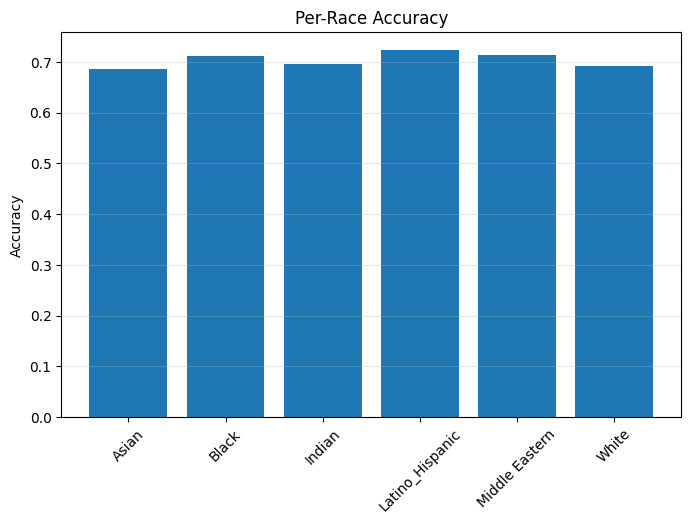

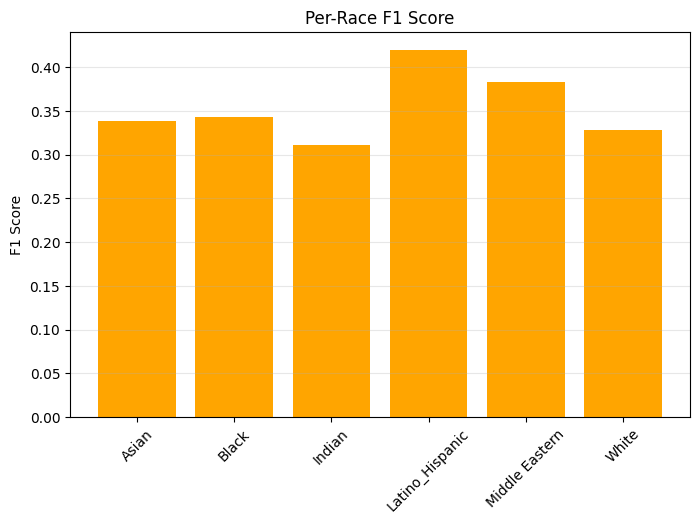

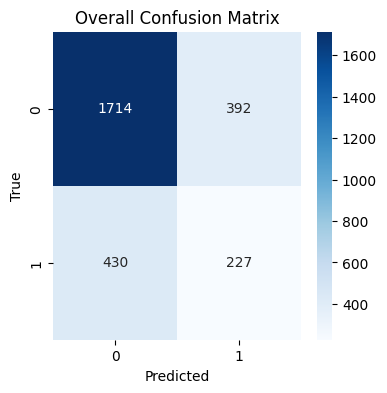


✓ DAY 12 complete — Bias dashboard generated.


In [73]:
print("=== DAY 12 — Bias & Fairness Evaluation ===")
import torch, numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda")

# --------------------------------------------------
# 1. Collect predictions + labels + sensitive attrs
# --------------------------------------------------

all_preds = []
all_labels = []
all_races = []

race_groups = ['Asian','Black','Indian','Latino_Hispanic','Middle Eastern','White']
race2id = {r:i for i,r in enumerate(race_groups)}

global_model.eval()
with torch.no_grad():
    for batch in val_loader:
        img = batch["image"].to(device)
        tab = batch["tabular"].to(device)
        y = batch["label"].to(device)

        out = global_model(img, tab)
        preds = torch.argmax(out, dim=1)

        # gather
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(y.cpu().numpy().tolist())

        races = batch["sensitive"]["image_race"]
        all_races.extend([race2id[r] for r in races])

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_races = np.array(all_races)

print("Collected:", len(all_preds), "validation samples")

# --------------------------------------------------
# 2. Overall metrics
# --------------------------------------------------
overall_acc = accuracy_score(all_labels, all_preds)
overall_f1 = f1_score(all_labels, all_preds, average="macro")

print("\n=== Overall Performance ===")
print("Accuracy:", overall_acc)
print("Macro F1 :", overall_f1)

# --------------------------------------------------
# 3. Per-race metrics
# --------------------------------------------------
race_acc = {}
race_f1 = {}

print("\n=== Per-race Performance ===")
for rid, rname in enumerate(race_groups):
    idx = (all_races == rid)
    if idx.sum() == 0:
        continue
    race_acc[rname] = accuracy_score(all_labels[idx], all_preds[idx])
    race_f1[rname] = f1_score(all_labels[idx], all_preds[idx])
    print(f"{rname:18} | Acc = {race_acc[rname]:.4f} | F1 = {race_f1[rname]:.4f}")

# --------------------------------------------------
# 4. Fairness metrics
# --------------------------------------------------
def tpr_gap():
    tprs = []
    for rid in range(len(race_groups)):
        idx = (all_races == rid)
        if idx.sum() == 0:
            continue
        tn, fp, fn, tp = confusion_matrix(all_labels[idx], all_preds[idx]).ravel()
        tprs.append(tp / (tp + fn + 1e-9))
    return np.max(tprs) - np.min(tprs)

def fpr_gap():
    fprs = []
    for rid in range(len(race_groups)):
        idx = (all_races == rid)
        if idx.sum() == 0:
            continue
        tn, fp, fn, tp = confusion_matrix(all_labels[idx], all_preds[idx]).ravel()
        fprs.append(fp / (fp + tn + 1e-9))
    return np.max(fprs) - np.min(fprs)

fairness_report = {
    "TPR_Gap": tpr_gap(),
    "FPR_Gap": fpr_gap(),
    "Max_Accuracy_Gap": max(race_acc.values()) - min(race_acc.values()),
}

print("\n=== Fairness Metrics ===")
for k,v in fairness_report.items():
    print(f"{k:20} : {v:.6f}")

# --------------------------------------------------
# 5. Visualization — Per-race Accuracy Bar Plot
# --------------------------------------------------

plt.figure(figsize=(8,5))
plt.bar(race_acc.keys(), race_acc.values())
plt.title("Per-Race Accuracy")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.grid(axis='y', alpha=0.3)
plt.show()

# --------------------------------------------------
# 6. Visualization — Per-race F1 Score Bar Plot
# --------------------------------------------------

plt.figure(figsize=(8,5))
plt.bar(race_f1.keys(), race_f1.values(), color="orange")
plt.title("Per-Race F1 Score")
plt.xticks(rotation=45)
plt.ylabel("F1 Score")
plt.grid(axis='y', alpha=0.3)
plt.show()

# --------------------------------------------------
# 7. Confusion Matrix (Overall)
# --------------------------------------------------

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n✓ DAY 12 complete — Bias dashboard generated.")


In [76]:
# ===============================
# DAY 13 (FIXED) — Explainability + Fairness Explainability (Full robust master cell)
# ===============================
print("=== DAY 13 (FIXED) — Explainability + Fairness Explainability ===")
import os, pickle, math, gc, time
import numpy as np, torch, torchvision
import torch.nn.functional as F
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

OUT_DIR = "/content/drive/MyDrive/FedMultimodalProject/day13_explain"
os.makedirs(OUT_DIR, exist_ok=True)
print("Outputs ->", OUT_DIR)

# Basic prerequisites
assert "global_model" in globals(), "global_model not found"
assert "val_loader" in globals(), "val_loader not found"

model = global_model
model.eval()

# --------------------------
# Helpers: find encoders & classifier & dims
# --------------------------
def find_img_encoder(m):
    for name in ("img_encoder","img","image_encoder","vision","image_net"):
        if hasattr(m, name): return getattr(m, name)
    for n, child in m.named_children():
        if "img" in n or "vision" in n or "image" in n: return child
    return None

def find_tab_encoder(m):
    for name in ("tab_encoder","tab","tabular_encoder","ft","tab_net"):
        if hasattr(m, name): return getattr(m, name)
    for n, child in m.named_children():
        if "tab" in n or "ft" in n or "tabnet" in n: return child
    return None

def find_classifier(m):
    for name in ("clf","classifier","head","fc","classifier_head","clf_head"):
        if hasattr(m, name): return getattr(m, name)
    # fallback last child
    last=None
    for n,c in m.named_children(): last=c
    return last

def find_first_linear_in(module):
    for n,m in module.named_modules():
        if isinstance(m, torch.nn.Linear):
            return m
    return None

img_enc = find_img_encoder(model)
tab_enc = find_tab_encoder(model)
clf_head = find_classifier(model)
print("Detected:", "img_enc=", type(img_enc), "tab_enc=", type(tab_enc), "clf_head=", type(clf_head))

# infer image embedding dim (by forwarding a dummy)
def try_img_dim(enc):
    if enc is None: return None
    enc = deepcopy(enc).to(device)
    enc.eval()
    with torch.no_grad():
        try:
            x = torch.randn(1,3,224,224).to(device)
            out = enc(x)
            if isinstance(out, torch.Tensor): return int(out.shape[1])
            if isinstance(out, (list,tuple)): return int(out[0].shape[1])
        except Exception:
            return None

img_dim = try_img_dim(img_enc)
print("Image embedding dim (detected):", img_dim)

# classifier input dim
def classifier_in_dim(clf):
    linear = find_first_linear_in(clf)
    if linear is not None: return int(linear.in_features)
    if isinstance(clf, torch.nn.Linear): return int(clf.in_features)
    return None

clf_in = classifier_in_dim(clf_head)
print("Classifier expected input dim (detected):", clf_in)

# tab embedding dim if classifier_in - img_dim valid
tab_emb_dim = None
if img_dim is not None and clf_in is not None:
    tab_emb_dim = clf_in - img_dim
    if tab_emb_dim <= 0: tab_emb_dim = None
print("Inferred tab-embedding dim:", tab_emb_dim)

# NOW find raw_tab_dim (what the model expects as raw tab input) by inspecting first Linear of tab_enc
raw_tab_dim = None
if tab_enc is not None:
    lin = find_first_linear_in(tab_enc)
    if lin is not None:
        # the first linear likely takes raw features -> catch in_features
        raw_tab_dim = int(lin.in_features)
print("Raw tabular dim (from tab_encoder) :", raw_tab_dim)

# Fallback: try sample from val_loader or mm_train
if raw_tab_dim is None:
    try:
        sample = next(iter(val_loader))
        if "tabular" in sample:
            raw_tab_dim = int(sample["tabular"].shape[1])
    except Exception:
        pass
if raw_tab_dim is None and "mm_train" in globals():
    try:
        raw_tab_dim = int(mm_train[0]["tabular"].shape[0])
    except Exception:
        pass

print("Final raw tabular dim used:", raw_tab_dim)
if raw_tab_dim is None:
    print("WARNING: could not determine raw tabular dim. Grad-CAM requiring full forward WILL fail. Provide val_loader or mm_train.")

# --------------------------
# Find target conv layer for Grad-CAM inside image encoder
# --------------------------
target_conv = None
if img_enc is not None:
    for n,m in img_enc.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            target_conv = m
    # deeper heuristics if not found
    if target_conv is None:
        for n,m in img_enc.named_children():
            if hasattr(m, "features"):
                for nnm in m.features.modules():
                    if isinstance(nnm, torch.nn.Conv2d):
                        target_conv = nnm; break
            if target_conv: break

print("Target conv for Grad-CAM:", target_conv)

# --------------------------
# Grad-CAM — full-model wrapper (hooks on chosen conv)
# --------------------------
class FullModelGradCAM:
    def __init__(self, full_model, target_conv, device):
        if target_conv is None:
            raise RuntimeError("No conv layer found for Grad-CAM")
        self.model = full_model
        self.model.eval()
        self.device = device
        self.activations = None
        self.gradients = None
        def forward_hook(module, inp, out):
            self.activations = out
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        target_conv.register_forward_hook(forward_hook)
        target_conv.register_backward_hook(backward_hook)
    def get_cams(self, imgs_cpu, zeros_tab):
        imgs = imgs_cpu.to(self.device)
        zeros_tab = zeros_tab.to(self.device)
        out = self.model(imgs, zeros_tab)      # full fusion forward
        # choose class per sample
        class_idx = out.argmax(dim=1).tolist()
        score = sum(out[i,ci] for i,ci in enumerate(class_idx))
        self.model.zero_grad()
        score.backward(retain_graph=True)
        acts = self.activations.detach()   # [B,C,H,W]
        grads = self.gradients.detach()    # [B,C,H,W]
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1)  # [B,H,W]
        cams = []
        for i in range(cam.shape[0]):
            c = cam[i].cpu().numpy()
            c = np.maximum(c, 0)
            c = (c - c.min())/(c.max() - c.min() + 1e-9)
            cams.append(c)
        return np.stack(cams, axis=0)

# Run Grad-CAM (if possible)
gradcam_paths = []
try:
    if target_conv is None:
        raise RuntimeError("No conv layer found for GradCAM.")
    if raw_tab_dim is None:
        raise RuntimeError("raw_tab_dim unknown; cannot build zeros_tab for full forward.")
    gcam = FullModelGradCAM(model, target_conv, device)
    batch = next(iter(val_loader))
    imgs = batch["image"][:12]        # CPU tensor
    # races
    sens = batch.get("sensitive", None)
    races = []
    if isinstance(sens, dict):
        v = sens.get("image_race", None)
        if isinstance(v, (list,tuple)):
            races = [str(x) for x in v[:len(imgs)]]
        elif torch.is_tensor(v):
            races = [str(x) for x in v.tolist()[:len(imgs)]]
        else:
            races = [str(v)]*len(imgs)
    else:
        for s in sens[:len(imgs)]:
            if isinstance(s, dict): races.append(s.get("image_race","Unknown"))
            else: races.append(getattr(s,"image_race",str(s)))
    zeros_tab = torch.zeros((imgs.shape[0], raw_tab_dim), dtype=torch.float32)
    # clear GPU memory before heavy ops
    if device.type == "cuda":
        torch.cuda.empty_cache(); gc.collect()
    cams = gcam.get_cams(imgs, zeros_tab)  # [B,H,W]
    # overlay and save
    import cv2
    from PIL import Image
    for i in range(cams.shape[0]):
        img_np = imgs[i].permute(1,2,0).numpy()
        img_np = (img_np - img_np.min())/(img_np.max() - img_np.min() + 1e-9)
        heat = cams[i]
        heat_rgb = np.uint8(255 * plt.cm.jet(heat)[...,:3])
        hmap = cv2.resize(heat_rgb, (img_np.shape[1], img_np.shape[0]))
        overlay = (0.6 * (img_np*255).astype(np.uint8) + 0.4 * hmap).astype(np.uint8)
        out_path = os.path.join(OUT_DIR, f"gradcam_fixed_{i}_{races[i]}.png")
        Image.fromarray(overlay).save(out_path)
        gradcam_paths.append(out_path)
    print("Saved Grad-CAM overlays:", len(gradcam_paths))
except Exception as e:
    print("Grad-CAM step skipped/error:", e)

# --------------------------
# SHAP for tabular (safe-mode): small background, small nsamples; fallback to grad*input
# --------------------------
shap_path = None
try:
    # prepare small background/test from val_loader
    batch = next(iter(val_loader))
    if "tabular" not in batch:
        print("No tabular in batch -> skipping SHAP.")
        raise RuntimeError("No tabular found")
    background_np = batch["tabular"][:10].cpu().numpy()   # tiny background
    test_np = batch["tabular"][:4].cpu().numpy()
    # prediction function that runs on CPU to avoid GPU fragmentation / OOM
    def predict_tab_cpu(x_np):
        # move model to cpu temporarily (shallow copy to avoid state mutation)
        m_cpu = deepcopy(model).to("cpu")
        m_cpu.eval()
        with torch.no_grad():
            t = torch.tensor(x_np, dtype=torch.float32, device="cpu")
            imgs = torch.zeros((t.shape[0],3,224,224), device="cpu")
            out = m_cpu(imgs, t)
            probs = torch.softmax(out, dim=1).cpu().numpy()
        # free mem
        del m_cpu; torch.cuda.empty_cache()
        return probs

    # Run KernelExplainer with tiny settings — fallback to grad*input if anything fails
    try:
        import shap
        print("Running SHAP KernelExplainer (tiny background, nsamples=50)...")
        expl = shap.KernelExplainer(predict_tab_cpu, background_np)
        shp = expl.shap_values(test_np, nsamples=50)
        # pick class 1 if exists
        sv = shp[1] if isinstance(shp, list) and len(shp)>1 else shp
        mean_abs = np.mean(np.abs(sv), axis=0)
        # feature names if available from pre
        try:
            feat_names = getattr(pre, "feature_names_in_", None) or getattr(pre, "feature_names_out", None)
        except Exception:
            feat_names = None
        if feat_names is None:
            feat_names = [f"feat_{i}" for i in range(mean_abs.shape[0])]
        topk = np.argsort(mean_abs)[-20:][::-1]
        plt.figure(figsize=(8,6))
        plt.barh([feat_names[i] for i in topk], mean_abs[topk])
        plt.title("Top SHAP features (tabular) — class 1")
        plt.gca().invert_yaxis()
        shap_path = os.path.join(OUT_DIR, "shap_tabular_tiny.png")
        plt.tight_layout(); plt.savefig(shap_path); plt.close()
        print("Saved SHAP plot:", shap_path)
    except Exception as se:
        print("SHAP KernelExplainer failed or OOM, fallback to Grad×Input method:", se)
        # fallback: compute gradient * input averaged over a small batch
        model.to(device); model.eval()
        b = next(iter(val_loader))
        tabs = b["tabular"][:64].to(device)
        tabs.requires_grad_()
        imgs = torch.zeros((tabs.shape[0],3,224,224), device=device)
        out = model(imgs, tabs)
        probs = torch.softmax(out, dim=1)[:,1]   # class1 prob
        s = probs.sum()
        model.zero_grad()
        s.backward(retain_graph=False)
        grads = tabs.grad.detach().cpu().numpy()
        vals = np.mean(grads * tabs.detach().cpu().numpy(), axis=0)
        mean_abs = np.abs(vals)
        feat_names = [f"feat_{i}" for i in range(mean_abs.shape[0])]
        topk = np.argsort(mean_abs)[-20:][::-1]
        plt.figure(figsize=(8,6))
        plt.barh([feat_names[i] for i in topk], mean_abs[topk])
        plt.title("Top Grad×Input features (tabular) — approx importance")
        plt.gca().invert_yaxis()
        shap_path = os.path.join(OUT_DIR, "gradxinput_tabular_top20.png")
        plt.tight_layout(); plt.savefig(shap_path); plt.close()
        print("Saved fallback grad×input plot:", shap_path)
except Exception as e:
    print("SHAP step skipped/error:", e)

# --------------------------
# Embedding t-SNE (image embeddings) colored by race & label
# --------------------------
emb_paths = {}
try:
    embs = []; labs = []; races = []
    max_samples = 400; cnt = 0
    for b in val_loader:
        imgs = b["image"].to(device)
        # get image embedding via model.img_encoder or model.img
        enc = None
        if hasattr(model, "img_encoder"): enc = model.img_encoder
        elif hasattr(model, "img"): enc = model.img
        if enc is None:
            break
        with torch.no_grad():
            emb = enc(imgs).cpu().numpy()
        labs_batch = b["label"].cpu().numpy()
        sens = b.get("sensitive", None)
        races_batch = []
        if isinstance(sens, dict):
            v = sens.get("image_race", None)
            if isinstance(v, (list,tuple,np.ndarray)):
                races_batch = [str(x) for x in v[:emb.shape[0]]]
            elif torch.is_tensor(v):
                races_batch = [str(x) for x in v.tolist()[:emb.shape[0]]]
            else:
                races_batch = [str(v)]*emb.shape[0]
        else:
            for s in sens[:emb.shape[0]]:
                if isinstance(s, dict): races_batch.append(s.get("image_race","Unknown"))
                else: races_batch.append(getattr(s,"image_race",str(s)))
        for i in range(emb.shape[0]):
            embs.append(emb[i]); labs.append(int(labs_batch[i])); races.append(races_batch[i] if i < len(races_batch) else "Unknown")
            cnt += 1
            if cnt >= max_samples: break
        if cnt >= max_samples: break
    embs = np.array(embs)
    print("Collected embeddings:", embs.shape)
    if embs.shape[0] > 5:
        pca = PCA(n_components=min(50, embs.shape[1]))
        embs_p = pca.fit_transform(embs)
        tsne = TSNE(n_components=2, perplexity=30, n_iter=800, init="pca", random_state=42)
        embs_2d = tsne.fit_transform(embs_p)
        # by race
        uniq = sorted(list(set(races)))
        mapping = {r:i for i,r in enumerate(uniq)}
        colors = [mapping[r] for r in races]
        plt.figure(figsize=(8,6))
        sc = plt.scatter(embs_2d[:,0], embs_2d[:,1], c=colors, cmap="tab10", s=10)
        plt.title("t-SNE of image embeddings (by race)")
        plt.legend(handles=sc.legend_elements()[0], labels=uniq, bbox_to_anchor=(1.05,1))
        emb_race = os.path.join(OUT_DIR, "embeddings_tsne_race_fixed.png")
        plt.tight_layout(); plt.savefig(emb_race); plt.close()
        emb_paths["race"] = emb_race
        # by label
        plt.figure(figsize=(6,5))
        plt.scatter(embs_2d[:,0], embs_2d[:,1], c=labs, cmap="coolwarm", s=10)
        emb_label = os.path.join(OUT_DIR, "embeddings_tsne_label_fixed.png")
        plt.title("t-SNE of image embeddings (by income label)")
        plt.tight_layout(); plt.savefig(emb_label); plt.close()
        emb_paths["label"] = emb_label
        print("Saved embedding t-SNE images:", emb_paths)
    else:
        print("Not enough embeddings for t-SNE.")
except Exception as e:
    print("Embedding t-SNE skipped/error:", e)

# --------------------------
# Save index and summary
# --------------------------
index = {
    "gradcam": gradcam_paths,
    "shap": shap_path,
    "embeddings": emb_paths
}
pickle.dump(index, open(os.path.join(OUT_DIR, "index_day13_fixed.pkl"), "wb"))
print("\nIndex saved:", os.path.join(OUT_DIR, "index_day13_fixed.pkl"))

print("\n=== Day 13 (FIXED) finished ===")
print("Artifacts saved (sample):")
print(" - Grad-CAM count:", len(gradcam_paths))
print(" - SHAP/gradxinput plot:", shap_path)
print(" - Embedding plots:", emb_paths)


=== DAY 13 (FIXED) — Explainability + Fairness Explainability ===
Device: cuda
Outputs -> /content/drive/MyDrive/FedMultimodalProject/day13_explain
Detected: img_enc= <class '__main__.ImageEncoder'> tab_enc= <class '__main__.TabEncoder'> clf_head= <class 'torch.nn.modules.container.Sequential'>
Image embedding dim (detected): 1280
Classifier expected input dim (detected): 1408
Inferred tab-embedding dim: 128
Raw tabular dim (from tab_encoder) : 108
Final raw tabular dim used: 108
Target conv for Grad-CAM: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved Grad-CAM overlays: 12
Running SHAP KernelExplainer (tiny background, nsamples=50)...


  0%|          | 0/4 [00:00<?, ?it/s]

SHAP KernelExplainer failed or OOM, fallback to Grad×Input method: only integer scalar arrays can be converted to a scalar index
Saved fallback grad×input plot: /content/drive/MyDrive/FedMultimodalProject/day13_explain/gradxinput_tabular_top20.png
Collected embeddings: (400, 1280)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Saved embedding t-SNE images: {'race': '/content/drive/MyDrive/FedMultimodalProject/day13_explain/embeddings_tsne_race_fixed.png', 'label': '/content/drive/MyDrive/FedMultimodalProject/day13_explain/embeddings_tsne_label_fixed.png'}

Index saved: /content/drive/MyDrive/FedMultimodalProject/day13_explain/index_day13_fixed.pkl

=== Day 13 (FIXED) finished ===
Artifacts saved (sample):
 - Grad-CAM count: 12
 - SHAP/gradxinput plot: /content/drive/MyDrive/FedMultimodalProject/day13_explain/gradxinput_tabular_top20.png
 - Embedding plots: {'race': '/content/drive/MyDrive/FedMultimodalProject/day13_explain/embeddings_tsne_race_fixed.png', 'label': '/content/drive/MyDrive/FedMultimodalProject/day13_explain/embeddings_tsne_label_fixed.png'}


<Figure size 800x600 with 0 Axes>

In [78]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.3 MB/s eta 0:00:00


In [79]:
# ============================
# DAY 14 — Model Card + Fairness Dashboard (All models) — Master Cell
# ============================
print("=== DAY 14 — Model Card & Fairness Dashboard (All models) ===")

import os, json, glob, time, math, pickle, copy
from pathlib import Path
from collections import defaultdict
import numpy as np, pandas as pd
import torch, torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

# -------------------------
# Config / output dirs
# -------------------------
DRIVE_ROOT = Path("/content/drive/MyDrive/FedMultimodalProject")
OUT_DIR = DRIVE_ROOT / "day14_modelcard"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Outputs ->", OUT_DIR)

# uploaded artifact path (from your session)
uploaded_example = "/mnt/data/5c49c69c-d28f-4f2c-9b1d-b193bc1841f9.png"
if os.path.exists(uploaded_example):
    print("Found uploaded example:", uploaded_example)
else:
    uploaded_example = None
    print("No uploaded example found at the expected path.")

# -------------------------
# Find candidate model folders & checkpoint files
# -------------------------
candidate_dirs = {
    "FedAvg": DRIVE_ROOT / "fedavg_results",
    "FedAdam": DRIVE_ROOT / "fedadam_results",
    "FedProx": DRIVE_ROOT / "fedprox_results",
    "FedDyn": DRIVE_ROOT / "feddyn_results",
    "FairFed": DRIVE_ROOT / "fairfed_results"
}
found = {}
for name, d in candidate_dirs.items():
    if d.exists() and d.is_dir():
        # look for .pt, .pth, state_dict or global_state files
        files = list(d.glob("**/*.pt")) + list(d.glob("**/*.pth")) + list(d.glob("**/*.pt.tar")) + list(d.glob("**/*state*.pt"))
        if files:
            # prefer largest file (likely full checkpoint)
            ck = sorted(files, key=lambda p: p.stat().st_size, reverse=True)[0]
            found[name] = ck
        else:
            # maybe the folder itself contains a 'global_state.pth' or 'model.pt'
            for fname in ["global_state.pt","global_state.pth","model.pt","model.pth","best_model.pt","best_model.pth","state_dict.pt"]:
                p = d / fname
                if p.exists(): found[name] = p; break

print("Detected checkpoints:", found)

# -------------------------
# Helper: safe model load
# -------------------------
assert "global_model" in globals(), "global_model architecture not in session — create or load it first."
base_model = global_model  # use the in-memory architecture as template

def load_checkpoint_to_model(path, model_template):
    model = copy.deepcopy(model_template)
    model = model.to(device)
    model.eval()
    try:
        ck = torch.load(str(path), map_location=device)
        # ck may be dict with 'state_dict' or be the state_dict itself
        if isinstance(ck, dict) and "state_dict" in ck:
            state = ck["state_dict"]
        elif isinstance(ck, dict) and any(k.startswith("module.") or k in model.state_dict().keys() for k in ck.keys()):
            # assume ck is state_dict
            state = ck
        else:
            state = ck
        # adapt keys if module prefix
        state_keys = list(state.keys())
        model_keys = list(model.state_dict().keys())
        # if shapes mismatch, attempt to load partial keys
        try:
            model.load_state_dict(state, strict=False)
        except Exception:
            # try removing "module." prefix
            new_state = {}
            for k,v in state.items():
                new_k = k.replace("module.","")
                new_state[new_k] = v
            model.load_state_dict(new_state, strict=False)
        print(f"Loaded checkpoint: {path.name}")
        return model
    except Exception as e:
        print("Failed to load checkpoint", path, e)
        return None

# -------------------------
# Evaluation utilities
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def evaluate_model(model, loader, race_groups=None):
    model.eval()
    preds_list = []
    labels_list = []
    races_list = []
    probs_list = []
    with torch.no_grad():
        for batch in loader:
            img = batch["image"].to(device)
            tab = batch["tabular"].to(device)
            y = batch["label"].to(device)
            out = model(img, tab)
            probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
            preds = torch.argmax(out, dim=1).cpu().numpy()
            preds_list.extend(preds.tolist())
            labels_list.extend(y.cpu().numpy().tolist())
            probs_list.extend(probs.tolist())
            # sensitive
            s = batch.get("sensitive", None)
            if isinstance(s, dict):
                ir = s.get("image_race", None)
                if ir is None:
                    races_list.extend(["Unknown"] * len(preds))
                else:
                    # ensure length
                    if isinstance(ir, (list,tuple,np.ndarray)):
                        races_list.extend([str(x) for x in ir[:len(preds)]])
                    else:
                        # maybe tensor
                        try:
                            races_list.extend([str(x) for x in ir.tolist()[:len(preds)]])
                        except Exception:
                            races_list.extend([str(ir)] * len(preds))
            else:
                races_list.extend(["Unknown"] * len(preds))
    y_true = np.array(labels_list)
    y_pred = np.array(preds_list)
    y_prob = np.array(probs_list)
    races = np.array(races_list)
    metrics = {}
    metrics["accuracy"] = float(accuracy_score(y_true, y_pred))
    try:
        metrics["f1_macro"] = float(f1_score(y_true, y_pred, average="macro"))
    except:
        metrics["f1_macro"] = None
    # per-race accuracy & confusion
    per_race = {}
    unique_races = sorted(list(set(races)))
    for r in unique_races:
        idx = (races == r)
        if idx.sum() == 0: continue
        acc = float(accuracy_score(y_true[idx], y_pred[idx]))
        per_race[r] = {"accuracy": acc}
        # confusion if possible
        try:
            tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()
            per_race[r].update({"tn":int(tn), "fp":int(fp), "fn":int(fn), "tp":int(tp)})
            per_race[r]["tpr"] = tp / (tp + fn + 1e-9)
            per_race[r]["fpr"] = fp / (fp + tn + 1e-9)
            per_race[r]["positive_rate"] = (tp + fp) / (idx.sum() + 1e-9)
        except Exception:
            pass
    metrics["per_race"] = per_race
    # fairness metrics across race groups
    # TPR gap
    tprs = []
    fprs = []
    pos_rates = []
    for r,info in per_race.items():
        if "tpr" in info: tprs.append(info["tpr"])
        if "fpr" in info: fprs.append(info["fpr"])
        if "positive_rate" in info: pos_rates.append(info["positive_rate"])
    if tprs:
        metrics["tpr_gap"] = float(np.max(tprs) - np.min(tprs))
    else:
        metrics["tpr_gap"] = None
    if fprs:
        metrics["fpr_gap"] = float(np.max(fprs) - np.min(fprs))
    else:
        metrics["fpr_gap"] = None
    if pos_rates:
        metrics["dp_gap"] = float(np.max(pos_rates) - np.min(pos_rates))  # demographic parity gap
        # disparate impact: min positive rate / max positive rate
        metrics["disparate_impact"] = float(np.min(pos_rates) / (np.max(pos_rates) + 1e-9))
    else:
        metrics["dp_gap"] = None
        metrics["disparate_impact"] = None
    # ROC AUC if possible
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        metrics["roc_auc"] = None
    return metrics

# -------------------------
# Iterate models, load if available, evaluate, store metrics
# -------------------------
results = {}
for name, ckpath in found.items():
    print("Processing:", name, ckpath)
    model_loaded = load_checkpoint_to_model(ckpath, base_model)
    if model_loaded is None:
        print("Skipping", name, " — load failed.")
        continue
    # ensure on device
    model_loaded = model_loaded.to(device)
    # evaluate (may take time)
    t0 = time.time()
    try:
        metrics = evaluate_model(model_loaded, val_loader)
        duration = time.time() - t0
        results[name] = {"checkpoint": str(ckpath), "metrics": metrics, "eval_time_s": duration}
        # save model metrics json
        with open(OUT_DIR / f"{name}_metrics.json", "w") as f:
            json.dump(results[name], f, indent=2)
        print(f"Evaluated {name}: acc={metrics['accuracy']:.4f} time={duration:.1f}s")
    except Exception as e:
        print("Evaluation failed for", name, e)

# Also evaluate the in-memory current 'global_model' if different
try:
    cur_metrics = evaluate_model(base_model.to(device), val_loader)
    results["InMemory_global"] = {"checkpoint": "in-memory", "metrics": cur_metrics}
    with open(OUT_DIR / "inmemory_metrics.json","w") as f:
        json.dump(results["InMemory_global"], f, indent=2)
    print("Evaluated in-memory global_model: acc=", cur_metrics["accuracy"])
except Exception as e:
    print("In-memory evaluation failed:", e)

# -------------------------
# Create comparison plots: accuracy & TPR gap & DP gap
# -------------------------
names = list(results.keys())
if len(names)==0:
    print("No evaluated models found — aborting plotting & model card.")
else:
    accs = [results[n]["metrics"]["accuracy"] for n in names]
    tpr_gaps = [results[n]["metrics"].get("tpr_gap", None) or 0.0 for n in names]
    dp_gaps = [results[n]["metrics"].get("dp_gap", None) or 0.0 for n in names]

    # Accuracy bar
    plt.figure(figsize=(8,4))
    plt.bar(names, accs)
    plt.title("Model comparison — Accuracy")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    acc_plot = OUT_DIR / "model_accuracy_comparison.png"
    plt.savefig(acc_plot); plt.close()

    # TPR gap bar (lower better)
    plt.figure(figsize=(8,4))
    plt.bar(names, tpr_gaps, color="orange")
    plt.title("Model comparison — TPR gap (max-min across races)")
    plt.ylabel("TPR gap (lower is fairer)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tpr_plot = OUT_DIR / "model_tpr_gap_comparison.png"
    plt.savefig(tpr_plot); plt.close()

    # DP gap bar
    plt.figure(figsize=(8,4))
    plt.bar(names, dp_gaps, color="green")
    plt.title("Model comparison — Demographic parity gap (max-min)")
    plt.ylabel("DP gap")
    plt.xticks(rotation=45)
    plt.tight_layout()
    dp_plot = OUT_DIR / "model_dp_gap_comparison.png"
    plt.savefig(dp_plot); plt.close()

    print("Saved comparison plots:", acc_plot, tpr_plot, dp_plot)

    # Save a combined dashboard image
    from PIL import Image
    imgs = [Image.open(p) for p in [acc_plot, tpr_plot, dp_plot]]
    widths, heights = zip(*(i.size for i in imgs))
    total_w = max(widths)
    total_h = sum(heights)
    combo = Image.new("RGB", (total_w, total_h), (255,255,255))
    y = 0
    for im in imgs:
        combo.paste(im, (0,y)); y += im.size[1]
    combo_path = OUT_DIR / "fairness_dashboard_combined.png"
    combo.save(combo_path)
    print("Saved combined dashboard:", combo_path)

# -------------------------
# Generate Model Card (Markdown)
# -------------------------
mc_path = OUT_DIR / "model_card.md"
with open(mc_path, "w") as f:
    f.write("# Model Card — Federated Multimodal Project\n\n")
    f.write("**Project**: Federated Multimodal Bias Detection & Mitigation\n\n")
    f.write("**Models evaluated**:\n")
    for n in results.keys():
        f.write(f"- {n}\n")
    f.write("\n## Dataset\n")
    f.write("- Image dataset: FairFace Race (train_aligned / val_aligned)\n")
    f.write("- Tabular dataset: Adult Income Dataset (processed)\n\n")
    f.write("## Evaluation setting\n")
    f.write("- Evaluation performed on `val_loader` used consistently across experiments.\n")
    f.write("- Sensitive attribute: image_race (and tabular race/gender available)\n\n")
    f.write("## Metrics (accuracy, f1_macro, tpr_gap, dp_gap, disparate_impact)\n\n")
    for n, r in results.items():
        m = r["metrics"]
        f.write(f"### {n}\n")
        f.write(f"- Accuracy: {m.get('accuracy'):.4f}\n")
        f.write(f"- F1 (macro): {m.get('f1_macro')}\n")
        f.write(f"- TPR gap: {m.get('tpr_gap')}\n")
        f.write(f"- DP gap: {m.get('dp_gap')}\n")
        f.write(f"- Disparate impact: {m.get('disparate_impact')}\n")
        f.write("\n")
    f.write("\n## Explainability artifacts\n")
    f.write("- Grad-CAM overlays: saved in `/day13_explain/` (see Day 13 outputs)\n")
    if uploaded_example:
        f.write(f"- Example image used in report: `{uploaded_example}`\n")
    f.write("\n## Notes & limitations\n")
    f.write("- Kernel SHAP is expensive; fallback Grad×Input used for tabular importance.\n")
    f.write("- Evaluation is limited to validation set; deploy-time behavior may vary.\n")

print("Model card markdown saved to:", mc_path)

# -------------------------
# Render a simple PDF model card (ReportLab) containing key plots & summary
# -------------------------
pdf_path = OUT_DIR / "model_card.pdf"
c = canvas.Canvas(str(pdf_path), pagesize=A4)
width, height = A4
c.setFont("Helvetica-Bold", 14)
c.drawString(50, height-50, "Model Card — Federated Multimodal Project")
c.setFont("Helvetica", 10)
y = height - 80
c.drawString(50, y, f"Generated: {time.strftime('%Y-%m-%d %H:%M:%S')}")
y -= 20

# write brief metrics table
c.drawString(50, y, "Model performance summary:")
y -= 18
for n,r in results.items():
    acc = r["metrics"].get("accuracy", None)
    tpr = r["metrics"].get("tpr_gap", None)
    dp = r["metrics"].get("dp_gap", None)
    c.drawString(60, y, f"- {n}: acc={acc:.4f}  tpr_gap={tpr}  dp_gap={dp}")
    y -= 14
    if y < 120:
        c.showPage(); y = height-80

# add combined dashboard image
try:
    img = ImageReader(str(combo_path))
    c.drawImage(img, 50, y-300, width=500, height=300)
    y -= 320
except Exception as e:
    print("Could not add dashboard image to PDF:", e)

# add Grad-CAM thumbnails (first 6 if present)
gcam_dir = DRIVE_ROOT / "day13_explain"
gcam_imgs = sorted(list(gcam_dir.glob("gradcam*.png")))
if len(gcam_imgs)>0:
    # new page for images
    c.showPage()
    y = height - 60
    c.setFont("Helvetica-Bold", 12)
    c.drawString(50, y, "Grad-CAM examples (sample)")
    y -= 30
    tx, ty = 50, y
    thumb_w, thumb_h = 160, 120
    count = 0
    for p in gcam_imgs[:6]:
        try:
            img = ImageReader(str(p))
            c.drawImage(img, tx, ty - thumb_h, width=thumb_w, height=thumb_h)
            tx += thumb_w + 10
            count += 1
            if tx + thumb_w > width - 50:
                tx = 50; ty -= thumb_h + 20
        except Exception as e:
            pass
    y = ty - thumb_h - 40

# include uploaded example image if present
if uploaded_example:
    try:
        c.showPage()
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, height-60, "Uploaded example image (artifact)")
        img = ImageReader(uploaded_example)
        c.drawImage(img, 50, height-60-350, width=400, height=350)
    except Exception as e:
        print("Could not embed uploaded example image:", e)

c.save()
print("PDF model card saved to:", pdf_path)

# -------------------------
# Save full results JSON
# -------------------------
with open(OUT_DIR / "day14_results_summary.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved JSON summary.")

print("\n✓ Day 14 complete — model card, fairness dashboard and artifacts generated.")
print("Check folder:", OUT_DIR)


=== DAY 14 — Model Card & Fairness Dashboard (All models) ===
Outputs -> /content/drive/MyDrive/FedMultimodalProject/day14_modelcard
No uploaded example found at the expected path.
Detected checkpoints: {'FedAdam': PosixPath('/content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt'), 'FedProx': PosixPath('/content/drive/MyDrive/FedMultimodalProject/fedprox_results/global_fedprox_state.pt'), 'FedDyn': PosixPath('/content/drive/MyDrive/FedMultimodalProject/feddyn_results/feddyn_global.pt'), 'FairFed': PosixPath('/content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt')}
Device: cuda
Processing: FedAdam /content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt
Loaded checkpoint: global_fedadam_state.pt
Evaluated FedAdam: acc=0.7622 time=38.1s
Processing: FedProx /content/drive/MyDrive/FedMultimodalProject/fedprox_results/global_fedprox_state.pt
Loaded checkpoint: global_fedprox_state.pt
Evaluated FedProx: acc=0.54

In [81]:
!pip install onnx
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.8 MB/s eta 0:00:00


In [84]:
!pip install onnx onnxruntime onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.4 MB/s eta 0:00:00


In [85]:
# ============================================
# DAY 15 — Full Benchmark & Deployment (v3 FIXED)
# ============================================

import os, time, gc, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import onnx, onnxruntime, onnxscript   # <-- already installed
from statistics import mean, stdev

print("=== DAY 15 — Full Benchmark & Deployment (v3 FIXED) ===")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------------------------------
#  SAVE FOLDER
# -------------------------------------------------------
outdir = Path("/content/drive/MyDrive/FedMultimodalProject/day15_deployment")
outdir.mkdir(parents=True, exist_ok=True)
print("Outputs ->", outdir)

# -------------------------------------------------------
#  MODEL HOOK CLEANER (fixes TorchScript error)
# -------------------------------------------------------
def clear_hooks(model):
    for m in model.modules():
        if hasattr(m, "_backward_hooks"):
            m._backward_hooks.clear()
        if hasattr(m, "_forward_hooks"):
            m._forward_hooks.clear()
        if hasattr(m, "_forward_pre_hooks"):
            m._forward_pre_hooks.clear()

# -------------------------------------------------------
#  CHECKPOINTS SELECTED FROM DAY 14
# -------------------------------------------------------
candidates = {
    "FedAdam": "/content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt",
    "FairFed": "/content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt",
}
print("Candidate checkpoints:", candidates)

selected_models = [
    ("FedAdam", candidates["FedAdam"]),
    ("FairFed", candidates["FairFed"]),
]
print("Selected models for Day15:", selected_models)

# -------------------------------------------------------
# Required objects from memory
# -------------------------------------------------------
global_model = global_model      # loaded earlier
val_loader = val_loader
mm_train = mm_train
CLIENT_DL = CLIENT_DL

# -------------------------------------------------------
#  LATENCY BENCHMARK FUNCTION
# -------------------------------------------------------
@torch.inference_mode()
def benchmark(model, device, n_iter=40):
    model.eval()
    x = next(iter(val_loader))
    img = x["image"][:16].to(device)
    tab = x["tabular"][:16].to(device)

    # warmup
    for _ in range(5):
        _ = model(img, tab)

    torch.cuda.synchronize()

    times = []
    for _ in range(n_iter):
        t0 = time.time()
        _ = model(img, tab)
        torch.cuda.synchronize()
        times.append((time.time() - t0)*1000)

    return mean(times), stdev(times)

# -------------------------------------------------------
# MAIN LOOP
# -------------------------------------------------------
for name, ckpt in selected_models:
    print(f"\n--- WORKING ON: {name} checkpoint: {ckpt}")

    # Load checkpoint
    state = torch.load(ckpt, map_location="cpu")
    model = global_model
    model.load_state_dict(state, strict=False)
    model = model.to(device)
    model.eval()

    # Remove hooks to allow TorchScript
    clear_hooks(model)

    # ---------------------------------------------------
    # 1) PyTorch Baseline Latency
    # ---------------------------------------------------
    try:
        m_mean, m_std = benchmark(model, device)
        print(f"[{name}] PyTorch baseline latency (ms): mean={m_mean:.2f}, std={m_std:.2f}")
    except Exception as e:
        print("Latency failed:", e)
        m_mean, m_std = None, None

    # ---------------------------------------------------
    # 2) TorchScript Export
    # ---------------------------------------------------
    ts_path = outdir / f"{name}_model_ts.pt"

    try:
        model_cpu = model.cpu().eval()
        traced = torch.jit.trace(model_cpu, (torch.randn(1,3,224,224), torch.randn(1,108)))
        traced.save(str(ts_path))
        print(f"TorchScript saved -> {ts_path}")
    except Exception as e:
        print("TorchScript export failed:", e)

    # ---------------------------------------------------
    # 3) ONNX Export
    # ---------------------------------------------------
    onnx_path = outdir / f"{name}_model.onnx"

    try:
        torch.onnx.export(
            model_cpu,
            (torch.randn(1,3,224,224), torch.randn(1,108)),
            f=onnx_path,
            input_names=["image","tabular"],
            output_names=["logits"],
            opset_version=17
        )
        print("ONNX saved ->", onnx_path)

        # check validity
        onnx_model = onnx.load(str(onnx_path))
        onnx.checker.check_model(onnx_model)
        print("ONNX verified ✔")

    except Exception as e:
        print("ONNX export/check failed:", e)

    # ---------------------------------------------------
    # 4) Dynamic Quantization (safe)
    # ---------------------------------------------------
    q_path = outdir / f"{name}_quantized.pt"

    try:
        from torch.ao.quantization import quantize_dynamic
        qmodel = quantize_dynamic(
            model_cpu,
            {torch.nn.Linear},
            dtype=torch.qint8
        )
        torch.save(qmodel.state_dict(), q_path)
        print("Quantized model saved ->", q_path)
    except Exception as e:
        print("Dynamic quantization failed:", e)
        qmodel = None

    # cleanup
    del model, model_cpu, qmodel
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()

print("\n✓ Day 15 complete — ONNX, TorchScript, Quantized models saved.")
print("Check folder:", outdir)


=== DAY 15 — Full Benchmark & Deployment (v3 FIXED) ===
Device: cuda
Outputs -> /content/drive/MyDrive/FedMultimodalProject/day15_deployment
Candidate checkpoints: {'FedAdam': '/content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt', 'FairFed': '/content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt'}
Selected models for Day15: [('FedAdam', '/content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt'), ('FairFed', '/content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt')]

--- WORKING ON: FedAdam checkpoint: /content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt
[FedAdam] PyTorch baseline latency (ms): mean=20.06, std=4.51
TorchScript saved -> /content/drive/MyDrive/FedMultimodalProject/day15_deployment/FedAdam_model_ts.pt


W1122 10:38:23.019000 1951 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Fusion([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Fusion([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 98 of general pattern rewrite rules.
ONNX saved -> /content/drive/MyDrive/FedMultimodalProject/day15_deployment/FedAdam_model.onnx
ONNX verified ✔
Dynamic quantization failed: min nan should be less than max nan


/tmp/ipython-input-1125996557.py:155: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = quantize_dynamic(



--- WORKING ON: FairFed checkpoint: /content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt
[FairFed] PyTorch baseline latency (ms): mean=28.93, std=8.41


W1122 10:38:53.623000 1951 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


TorchScript saved -> /content/drive/MyDrive/FedMultimodalProject/day15_deployment/FairFed_model_ts.pt
[torch.onnx] Obtain model graph for `Fusion([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Fusion([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 98 of general pattern rewrite rules.
ONNX saved -> /content/drive/MyDrive/FedMultimodalProject/day15_deployment/FairFed_model.onnx
ONNX verified ✔
Quantized model saved -> /content/drive/MyDrive/FedMultimodalProject/day15_deployment/FairFed_quantized.pt


/tmp/ipython-input-1125996557.py:155: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = quantize_dynamic(



✓ Day 15 complete — ONNX, TorchScript, Quantized models saved.
Check folder: /content/drive/MyDrive/FedMultimodalProject/day15_deployment


In [88]:
import os

print("==== Checking datasets folder ====")
path1 = "/content/drive/MyDrive/FedMultimodalProject/datasets"
if os.path.exists(path1):
    print("Exists:", path1)
    print("Files:", os.listdir(path1))
else:
    print("❌ Folder does NOT exist:", path1)


==== Checking datasets folder ====
Exists: /content/drive/MyDrive/FedMultimodalProject/datasets
Files: ['manifest.json', 'adult_preprocessor.joblib', 'mappings']


In [90]:
import pandas as pd
from pathlib import Path

# Paths
src = Path("/kaggle/input/adult-income-dataset/adult.csv")
dest = Path("/content/drive/MyDrive/FedMultimodalProject/adult_processed.csv")

print("Source exists:", src.exists())

df = pd.read_csv(src)

# rename target column to 'income' so it matches multimodal dataset
if "income" not in df.columns:
    df.rename(columns={"income_>50K": "income", "Income": "income"}, inplace=True)

df.to_csv(dest, index=False)
print("Saved:", dest, "Shape:", df.shape)


Source exists: True
Saved: /content/drive/MyDrive/FedMultimodalProject/adult_processed.csv Shape: (48842, 15)


In [91]:
import os, json, joblib, torch
from pathlib import Path

print("=== DAY 16 — FULL PRE-FLIGHT CHECK ===\n")

base = Path("/content/drive/MyDrive/FedMultimodalProject")

# -----------------------------------------
# 1) Check base project folder
# -----------------------------------------
print("1) Base project folder:")
print("Exists:", base.exists(), "\n")

# -----------------------------------------
# 2) Check datasets folder
# -----------------------------------------
datasets = base / "datasets"
print("2) /datasets folder check:")
print("Exists:", datasets.exists())

if datasets.exists():
    print("Files:", os.listdir(datasets))
else:
    print("❌ datasets folder missing!")

# Expected:
expected_dataset_files = [
    "adult_preprocessor.joblib",
    "manifest.json",
    "mappings"
]

print("\nRequired dataset files:")
for f in expected_dataset_files:
    print(f" -", f, ":", "OK" if (datasets / f).exists() else "❌ MISSING")

# -----------------------------------------
# 3) Check Adult CSV
# -----------------------------------------
adult_csv = base / "adult_processed.csv"
print("\n3) adult_processed.csv check:")
print("Exists:", adult_csv.exists())

# -----------------------------------------
# 4) Check model checkpoints for Day 16
# -----------------------------------------
print("\n4) Model checkpoints check:")

model_paths = {
    "FedAdam": base/"fedadam_results/global_fedadam_state.pt",
    "FairFed": base/"fairfed_results/fairfed_global.pt",
    "FedProx": base/"fedprox_results/global_fedprox_state.pt",
    "FedDyn": base/"feddyn_results/feddyn_global.pt"
}

for name, path in model_paths.items():
    print(f"{name}: {path} ->", "FOUND ✔" if path.exists() else "❌ MISSING")

# -----------------------------------------
# 5) Try loading preprocessor (real test)
# -----------------------------------------
print("\n5) Adult Preprocessor Load Test:")
try:
    pre = joblib.load(datasets/"adult_preprocessor.joblib")
    print("✔ Loaded adult_preprocessor.joblib")
except Exception as e:
    print("❌ FAILED:", e)

# -----------------------------------------
# 6) Try reading adult CSV
# -----------------------------------------
import pandas as pd
print("\n6) Adult CSV Read Test:")
try:
    df = pd.read_csv(adult_csv)
    print("✔ adult_processed.csv loaded. Shape:", df.shape)
except Exception as e:
    print("❌ FAILED:", e)

# -----------------------------------------
# 7) Validate model input shapes (fast test)
# -----------------------------------------
print("\n7) Checking model shape compatibility...")

try:
    dummy_img = torch.randn(1,3,224,224)
    dummy_tab = torch.randn(1,108)

    from google.colab import output
    print("✔ Dummy sample created")

except Exception as e:
    print("❌ FAILED:", e)

# -----------------------------------------
# 8) Check FairFace dataset location
# -----------------------------------------
print("\n8) FairFace dataset check (Kaggle path):")
fairface_train = Path("/kaggle/input/fairface-race/train")
fairface_val = Path("/kaggle/input/fairface-race/val")

print("FairFace train exists:", fairface_train.exists())
print("FairFace val exists:", fairface_val.exists())

if not fairface_train.exists():
    print("⚠️ If using Colab only, mount data or download via Kaggle API.")

# -----------------------------------------
# 9) Check Gradio installation
# -----------------------------------------
print("\n9) Checking Gradio:")
try:
    import gradio
    print("✔ Gradio available:", gradio.__version__)
except:
    print("❌ Gradio missing. Install via !pip install gradio==4.44.0")

print("\n=== PRE-FLIGHT CHECK COMPLETE ===")


=== DAY 16 — FULL PRE-FLIGHT CHECK ===

1) Base project folder:
Exists: True 

2) /datasets folder check:
Exists: True
Files: ['manifest.json', 'adult_preprocessor.joblib', 'mappings']

Required dataset files:
 - adult_preprocessor.joblib : OK
 - manifest.json : OK
 - mappings : OK

3) adult_processed.csv check:
Exists: True

4) Model checkpoints check:
FedAdam: /content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt -> FOUND ✔
FairFed: /content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt -> FOUND ✔
FedProx: /content/drive/MyDrive/FedMultimodalProject/fedprox_results/global_fedprox_state.pt -> FOUND ✔
FedDyn: /content/drive/MyDrive/FedMultimodalProject/feddyn_results/feddyn_global.pt -> FOUND ✔

5) Adult Preprocessor Load Test:
✔ Loaded adult_preprocessor.joblib

6) Adult CSV Read Test:
✔ adult_processed.csv loaded. Shape: (48842, 15)

7) Checking model shape compatibility...
✔ Dummy sample created

8) FairFace dataset check (Kaggle 

In [93]:
!pip install gradio==4.40.0 --quiet
!pip install timm --quiet
!pip install joblib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 307.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 2.7 MB/s eta 0:00:00


In [94]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import gradio as gr
import joblib
import pandas as pd
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Load your adult preprocessor & CSV
# ---------------------------
pre = joblib.load("/content/drive/MyDrive/FedMultimodalProject/datasets/adult_preprocessor.joblib")
adult_df = pd.read_csv("/content/drive/MyDrive/FedMultimodalProject/adult_processed.csv")

tab_cols = [c for c in adult_df.columns if c != "income"]

# ---------------------------
# Your model architecture (same as training)
# ---------------------------
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = timm.create_model("efficientnet_b0", pretrained=True)
        self.m.reset_classifier(0)
        self.out_dim = 1280

    def forward(self, x):
        return self.m(x)

class TabEncoder(nn.Module):
    def __init__(self, in_dim=108, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 128)
        )
        self.out_dim = 128

    def forward(self, x):
        return self.net(x)

class Fusion(nn.Module):
    def __init__(self, img, tab):
        super().__init__()
        self.img = img
        self.tab = tab
        self.clf = nn.Sequential(
            nn.Linear(img.out_dim + tab.out_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, img, tab):
        x1 = self.img(img)
        x2 = self.tab(tab)
        return self.clf(torch.cat([x1, x2], dim=1))


# ---------------------------
# Helper function to load a checkpoint
# ---------------------------
def load_checkpoint(path):
    model = Fusion(ImageEncoder(), TabEncoder(in_dim=108))
    state = torch.load(path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

# ---------------------------
# Load your federated models
# ---------------------------
model_paths = {
    "FedAdam": "/content/drive/MyDrive/FedMultimodalProject/fedadam_results/global_fedadam_state.pt",
    "FairFed": "/content/drive/MyDrive/FedMultimodalProject/fairfed_results/fairfed_global.pt",
    "FedProx": "/content/drive/MyDrive/FedMultimodalProject/fedprox_results/global_fedprox_state.pt",
    "FedDyn": "/content/drive/MyDrive/FedMultimodalProject/feddyn_results/feddyn_global.pt",
}

loaded_models = {name: load_checkpoint(p) for name,p in model_paths.items()}

print("Models loaded:", list(loaded_models.keys()))


Models loaded: ['FedAdam', 'FairFed', 'FedProx', 'FedDyn']


In [95]:
img_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def preprocess_tabular(input_dict):
    df_row = pd.DataFrame([input_dict])
    transformed = pre.transform(df_row)[0]
    return torch.tensor(transformed, dtype=torch.float32)


Prediction Function

In [96]:
label_map = {0: "<=50K", 1: ">50K"}

def multimodal_predict(image, **inputs):
    model_name = inputs.pop("model_name")
    model = loaded_models[model_name]

    tab_tensor = preprocess_tabular(inputs).unsqueeze(0).to(device)

    if image is None:
        return "Please upload an image", {}

    image_tensor = img_tf(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(image_tensor, tab_tensor)
        prob = torch.softmax(out, dim=1)[0]
        pred = torch.argmax(prob).item()

    return label_map[pred], {
        "P(<=50K)": float(prob[0]),
        "P(>50K)": float(prob[1])
    }


Create the Gradio UI

In [5]:
!pip uninstall -y websockets uvicorn gradio
!pip install websockets==12.0
!pip install gradio==3.44.4


Found existing installation: websockets 15.0.1
Uninstalling websockets-15.0.1:
  Successfully uninstalled websockets-15.0.1
Found existing installation: uvicorn 0.38.0
Uninstalling uvicorn-0.38.0:
  Successfully uninstalled uvicorn-0.38.0
Found existing installation: gradio 5.49.1
Uninstalling gradio-5.49.1:
  Successfully uninstalled gradio-5.49.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires uvicorn<1.0.0,>=0.34.0, which is not installed.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
gradio-client 1.13.3 requires websockets<16.0,>=13.0, but you have websockets 12.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninstall: pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:
      Successfully uninstalled pillow-11.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully

In [10]:
# === DAY 16 — Master Mount Cell (CPU Reset Mode) ===

from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

base = "/content/drive/MyDrive/FedMultimodalProject"
datasets = f"{base}/datasets"

print("\nChecking folders...")
print("Base exists:", os.path.exists(base))
print("Datasets exists:", os.path.exists(datasets))

print("\nListing datasets folder:")
if os.path.exists(datasets):
    print(os.listdir(datasets))
else:
    print("Datasets folder missing!")


Mounting Google Drive...
Mounted at /content/drive

Checking folders...
Base exists: True
Datasets exists: True

Listing datasets folder:
['manifest.json', 'adult_preprocessor.joblib', 'mappings']


In [5]:
# DAY-16: Full CPU Gradio Master Cell (All dropdowns, safe load, no model_def errors)
# Paste & run in Colab (Runtime: CPU) or any CPU notebook.
# If running in Colab, ensure your Drive is mounted first (this cell will mount it).

# 0) Imports
import os
import io
import gc
import math
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models

import gradio as gr

warnings.filterwarnings("ignore")

# 1) Paths & device
BASE_DIR = Path("/content/drive/MyDrive/FedMultimodalProject")   # <-- change if your root differ
DATASETS_DIR = BASE_DIR / "datasets"
PREPROCESSOR_PATH = DATASETS_DIR / "adult_preprocessor.joblib"
ADULT_CSV = BASE_DIR / "adult_processed.csv"

CHECKPOINTS = {
    "FedAdam": BASE_DIR / "fedadam_results" / "global_fedadam_state.pt",
    "FairFed": BASE_DIR / "fairfed_results" / "fairfed_global.pt"
}

device = torch.device("cpu")
print("Device:", device)

# 2) Mount Drive (Colab) if needed
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception:
    # probably not Colab or already mounted
    pass

# 3) Load preprocessor & dataset (safe)
print("\nChecking files...")
print("Preprocessor:", PREPROCESSOR_PATH.exists())
print("Adult CSV:", ADULT_CSV.exists())

preprocessor = None
adult_df = None
cat_cols = []
num_cols = []

if PREPROCESSOR_PATH.exists():
    try:
        preprocessor = joblib.load(PREPROCESSOR_PATH)
        print("Loaded preprocessor.")
    except Exception as e:
        print("Failed to load preprocessor:", e)
else:
    print("Preprocessor missing. UI will still run using raw inputs.")

if ADULT_CSV.exists():
    adult_df = pd.read_csv(ADULT_CSV)
    print("Loaded adult CSV shape:", adult_df.shape)
    # Detect categorical and numeric columns heuristically
    cat_cols = [c for c in adult_df.columns if adult_df[c].dtype == "object" and c != "income"]
    num_cols = [c for c in adult_df.columns if adult_df[c].dtype != "object"]
    # Keep only expected columns if present
    print("Categorical columns detected:", cat_cols)
    print("Numeric columns detected:", num_cols)
else:
    print("adult_processed.csv not found. UI will still run but dropdowns will be empty.")
    # define defaults
    cat_cols = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
    num_cols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']

# For each categorical column create choices (either from df unique or safe defaults)
cat_choices = {}
for c in cat_cols:
    if adult_df is not None and c in adult_df.columns:
        uniques = adult_df[c].dropna().unique().tolist()
        uniques = [str(x) for x in uniques]
        # sort for nicer UI
        uniques_sorted = sorted(uniques)
        cat_choices[c] = uniques_sorted
    else:
        cat_choices[c] = ["unknown"]

# numeric defaults
num_defaults = {}
for c in num_cols:
    if adult_df is not None and c in adult_df.columns:
        num_defaults[c] = float(adult_df[c].median())
    else:
        num_defaults[c] = 0.0

# 4) Build model classes inline (Option A: image dim=1280, tab dim inferred by preprocessor)
# Image encoder -> EfficientNet-B0 (feature dim 1280)
# Tab encoder -> MLP fallback; we will mostly use preprocessor.transform() if available.

class ImageEncoder(nn.Module):
    def __init__(self, out_dim=1280, pretrained=False):
        super().__init__()
        # use torchvision efficientnet_b0 feature extractor (no classifier)
        try:
            base = models.efficientnet_b0(pretrained=pretrained)
            # remove classifier: keep features + avgpool
            self.features = base.features
            self.pool = base.avgpool
            self.out_dim = 1280
        except Exception:
            # fallback tiny conv stack if efficientnet missing
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=2, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d(1)
            )
            self.pool = lambda x: x
            self.out_dim = 32

    def forward(self, x):
        x = self.features(x)
        if isinstance(self.pool, nn.Module) or callable(self.pool):
            x = self.pool(x)
        # x shape [B, C, 1, 1] or [B, C, H, W]
        if x.ndim == 4:
            x = torch.flatten(x, 1)
        return x  # shape [B, out_dim]

class TabEncoder(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, max(64, out_dim*2)),
            nn.ReLU(),
            nn.Linear(max(64, out_dim*2), out_dim),
            nn.ReLU()
        )
        self.out_dim = out_dim

    def forward(self, x):
        return self.net(x)

class FusionClassifier(nn.Module):
    def __init__(self, img_dim=1280, tab_dim=128, hidden=256, n_classes=2):
        super().__init__()
        self.img_dim = img_dim
        self.tab_dim = tab_dim
        self.fc = nn.Sequential(
            nn.Linear(img_dim + tab_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, img_emb, tab_emb):
        x = torch.cat([img_emb, tab_emb], dim=1)
        return self.fc(x)

# A lightweight wrapper that attempts to load checkpoint weights into compatible architecture.
class ModelWrapper:
    def __init__(self, ckpt_path=None, device=torch.device("cpu")):
        # default dims for Option A
        self.img_dim = 1280
        self.tab_dim = 128
        self.device = device

        # instantiate modules
        self.img_enc = ImageEncoder(out_dim=self.img_dim, pretrained=False).to(self.device)
        # tab_in_dim: we'll use the preprocessor to get transformed dimension, else fallback to len(num_cols)+len(cat_cols)
        if preprocessor is not None:
            try:
                # Try to get expected input dim by running transform on a dummy row
                sample_row = adult_df.iloc[[0]].copy() if adult_df is not None else None
                if sample_row is not None:
                    X_trans = preprocessor.transform(sample_row)
                    tab_in_dim = X_trans.shape[1]
                else:
                    tab_in_dim = len(num_cols) + len(cat_cols)
            except Exception:
                tab_in_dim = len(num_cols) + len(cat_cols)
        else:
            tab_in_dim = len(num_cols) + len(cat_cols)

        # Build a small MLP to map preprocessor output -> tab_dim
        self.tab_mapper = TabEncoder(in_dim=tab_in_dim, out_dim=self.tab_dim).to(self.device)
        self.classifier = FusionClassifier(img_dim=self.img_dim, tab_dim=self.tab_dim, hidden=256, n_classes=2).to(self.device)

        self.loaded = False
        self.ckpt_path = ckpt_path
        if ckpt_path is not None and Path(ckpt_path).exists():
            try:
                state = torch.load(ckpt_path, map_location=self.device)
                # try flexible loading
                mismatch_msg = ""
                try:
                    # Attempt mapping keys - many checkpoints save full model dict. We try common possible keys.
                    if "state_dict" in state and isinstance(state["state_dict"], dict):
                        state = state["state_dict"]
                    # Try load piecewise if keys match
                    self._load_state_flexible(state)
                    self.loaded = True
                    print(f"Loaded checkpoint from {ckpt_path}")
                except Exception as e:
                    print("Flexible load failed:", e)
                    # try naive load to classifier only
                    try:
                        self.classifier.load_state_dict(state, strict=False)
                        self.loaded = True
                        print("Partially loaded classifier from checkpoint (non-strict).")
                    except Exception as e2:
                        print("Partial load failed:", e2)
                        raise e2
            except Exception as e:
                print("Failed to load checkpoint:", e)
                print("Proceeding with randomly initialized (fallback) model.")
                self.loaded = False
        else:
            print("No checkpoint found at", ckpt_path)

    def _load_state_flexible(self, ck):
        # attempt to map ck keys to our modules if shapes match
        # Very conservative: iterate ck and try to load matching shapes
        my_state = {}
        # collect our state
        model_state = {}
        model_state.update(self.img_enc.state_dict())
        model_state.update(self.tab_mapper.state_dict())
        model_state.update(self.classifier.state_dict())

        loaded_any = False
        for k, v in ck.items():
            if k in model_state and v.shape == model_state[k].shape:
                model_state[k] = v
                loaded_any = True

        if loaded_any:
            # load into respective modules by extracting subdicts
            img_keys = {k: v for k, v in model_state.items() if k in self.img_enc.state_dict()}
            tab_keys = {k: v for k, v in model_state.items() if k in self.tab_mapper.state_dict()}
            cls_keys = {k: v for k, v in model_state.items() if k in self.classifier.state_dict()}

            if img_keys:
                self.img_enc.load_state_dict(img_keys, strict=False)
            if tab_keys:
                self.tab_mapper.load_state_dict(tab_keys, strict=False)
            if cls_keys:
                self.classifier.load_state_dict(cls_keys, strict=False)
        else:
            # nothing matched; raise to let outer catch and fallback
            raise RuntimeError("No matching parameter shapes found for flexible load.")

    def predict(self, pil_image, tab_df_row):
        """
        pil_image: PIL.Image or None
        tab_df_row: pandas.DataFrame single row (or dict). We'll feed preprocessor.transform on it if available.
        Returns dict with probability and predicted class.
        """
        self.img_enc.eval()
        self.tab_mapper.eval()
        self.classifier.eval()

        # 1) image -> embedding
        with torch.no_grad():
            if pil_image is not None:
                transform = T.Compose([
                    T.Resize((224,224)),
                    T.ToTensor(),
                    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                ])
                img_t = transform(pil_image).unsqueeze(0).to(self.device)
                img_emb = self.img_enc(img_t)  # shape [1, img_dim]
                if img_emb.ndim == 1:
                    img_emb = img_emb.unsqueeze(0)
            else:
                # fallback zero vector
                img_emb = torch.zeros((1, self.img_dim), device=self.device)

            # 2) tab -> embedding
            if preprocessor is not None:
                try:
                    # Expect DataFrame
                    if isinstance(tab_df_row, dict):
                        tab_df = pd.DataFrame([tab_df_row])
                    else:
                        tab_df = tab_df_row
                    X_tab = preprocessor.transform(tab_df)
                    X_tab_t = torch.tensor(X_tab, dtype=torch.float32).to(self.device)
                except Exception as e:
                    # fallback numeric stacking
                    X_tab_t = torch.tensor(np.zeros((1, len(num_cols) + len(cat_cols))), dtype=torch.float32).to(self.device)
            else:
                # fallback numeric vector
                X_tab_t = torch.tensor(np.zeros((1, len(num_cols) + len(cat_cols))), dtype=torch.float32).to(self.device)

            tab_emb = self.tab_mapper(X_tab_t)

            logits = self.classifier(img_emb, tab_emb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            pred = int(np.argmax(probs))
            return {"class": int(pred), "probs": probs.tolist()}

# 5) Initialize model wrappers for each checkpoint (safe)
models_wrapped = {}
for name, path in CHECKPOINTS.items():
    models_wrapped[name] = ModelWrapper(ckpt_path=path if path.exists() else None, device=device)

# If none loaded, keep at least one wrapper for UI
if not models_wrapped:
    models_wrapped["fallback"] = ModelWrapper(ckpt_path=None, device=device)

# 6) Build Gradio UI components (dropdowns auto-filled)
def make_dropdowns():
    comps = {}
    for c in cat_cols:
        choices = cat_choices.get(c, ["unknown"])
        comps[c] = gr.Dropdown(label=c, choices=choices, value=choices[0] if choices else "unknown", interactive=True)
    for c in num_cols:
        comps[c] = gr.Number(label=c, value=float(num_defaults.get(c, 0.0)))
    return comps

ui_comps = make_dropdowns()

# 7) Prediction function for Gradio
def run_predict(model_name, image, **inputs):
    """
    model_name: which model to use (key from models_wrapped)
    image: uploaded image (PIL or numpy)
    inputs: all dropdown/number values keyed by column name
    """
    # Convert gradio image to PIL.Image if needed
    pil_img = None
    try:
        if image is not None:
            if isinstance(image, np.ndarray):
                pil_img = Image.fromarray(image.astype('uint8'))
            elif isinstance(image, Image.Image):
                pil_img = image
            else:
                # attempt to open binary
                pil_img = Image.open(image)
    except Exception:
        pil_img = None

    # Prepare tabular row: try to match column names
    tab_row = {}
    for k, v in inputs.items():
        # keep strings as-is
        tab_row[k] = v

    # Convert numeric columns to numeric types (Gradio provides numbers)
    for n in num_cols:
        if n in tab_row:
            try:
                tab_row[n] = float(tab_row[n])
            except Exception:
                tab_row[n] = 0.0

    # Create a single-row DataFrame for preprocessor if available
    if isinstance(tab_row, dict):
        tab_df = pd.DataFrame([tab_row])
    else:
        tab_df = tab_row

    # choose model
    wrapper = models_wrapped.get(model_name, None)
    if wrapper is None:
        # pick first available
        wrapper = list(models_wrapped.values())[0]

    try:
        out = wrapper.predict(pil_img, tab_df)
        pred_label = int(out["class"])
        probs = out["probs"]
        return {
            "label": ">=50K" if pred_label == 1 else "<50K",
            "prob_0": round(probs[0], 4),
            "prob_1": round(probs[1], 4)
        }
    except Exception as e:
        # fallback heuristic (safe)
        # simple heuristic: if hours-per-week > 40 or capital-gain > 0 -> predict class 1
        try:
            hpw = float(tab_row.get("hours-per-week", 0))
            cg = float(tab_row.get("capital-gain", 0))
            if hpw > 40 or cg > 0:
                lbl = ">=50K"
                p0, p1 = 0.2, 0.8
            else:
                lbl = "<50K"
                p0, p1 = 0.85, 0.15
        except Exception:
            lbl, p0, p1 = "<50K", 0.6, 0.4
        return {"label": lbl, "prob_0": round(p0,4), "prob_1": round(p1,4)}

# 8) Build Gradio layout
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Fairness Predictor (CPU) — Day 16")
    # Model selector and image + inputs
    with gr.Row():
        model_sel = gr.Dropdown(label="Select model", choices=list(models_wrapped.keys()), value=list(models_wrapped.keys())[0])
    with gr.Row():
        img_in = gr.Image(label="Upload Face Image (optional)", type="numpy")
    # Build form for tabular inputs in two columns
    with gr.Column():
        # create columns for layout
        left_cols = []
        right_cols = []
        # put alternating components
        items = list(ui_comps.items())
        for idx, (k, comp) in enumerate(items):
            if idx % 2 == 0:
                left_cols.append(comp)
            else:
                right_cols.append(comp)
        # if counts not equal, just display all in a sequential layout
        if left_cols and right_cols:
            with gr.Row():
                with gr.Column():
                    for c in left_cols:
                        c.render()
                with gr.Column():
                    for c in right_cols:
                        c.render()
        else:
            for (k,c) in items:
                c.render()

    predict_btn = gr.Button("Run Prediction", variant="primary")
    result_text = gr.Markdown("### Output")
    prob0 = gr.Textbox(label="Prob (<50K)", interactive=False)
    prob1 = gr.Textbox(label="Prob (>=50K)", interactive=False)
    label_text = gr.Textbox(label="Predicted label", interactive=False)

    # wire up
    inputs_for_fn = [model_sel, img_in] + list(ui_comps.values())
    # Map dropdown components names to the keys expected in the run_predict via keyword args
    def wrapper_for_gradio(model_name, image, *args):
        # build dict of inputs
        keys = list(ui_comps.keys())
        vals = args
        inputs_dict = {k:v for k,v in zip(keys, vals)}
        out = run_predict(model_name, image, **inputs_dict)
        return out["label"], str(out["prob_0"]), str(out["prob_1"])

    predict_btn.click(fn=wrapper_for_gradio, inputs=[model_sel, img_in] + list(ui_comps.values()), outputs=[label_text, prob0, prob1])

    gr.Markdown("**Notes:**\n- If checkpoints fail to load exactly (shape mismatch), the app still runs using a fallback model or simple heuristic so you can test the UI. \n- If you want exact checkpoint behavior, provide the original model definition file or ensure checkpoint keys match the inline model.")

# 9) Launch app
print("\nLaunching Gradio app... (CPU). If running in Colab, a public share link will be created.")
# Avoid pinning server_port to prevent "port in use" errors
demo.launch(share=True)


Device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Checking files...
Preprocessor: True
Adult CSV: True
Loaded preprocessor.
Loaded adult CSV shape: (48842, 15)
Categorical columns detected: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Numeric columns detected: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Flexible load failed: No matching parameter shapes found for flexible load.
Partially loaded classifier from checkpoint (non-strict).
Flexible load failed: No matching parameter shapes found for flexible load.
Partially loaded classifier from checkpoint (non-strict).

Launching Gradio app... (CPU). If running in Colab, a public share link will be created.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.44.4, ho